# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [3]:
import os
import sys
import json

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines

import jsonlines
import numpy as np
from collections import defaultdict

Installing the package, RESTART THIS CELL


## I. N-Gram Language Modeling

#### Utilities

In [0]:
#Data loading (load wikitext)
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

#Evaluating perplexity (perplexity())
def perplexity(model, sequences): 
    n_total = 0
    logp_total = 0
    for sequence in sequences:
      #print(model.sequence_logp(sequence))
      logp_total += model.sequence_logp(sequence)
      n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [6]:
datasets, vocab = load_wikitext()

--2019-10-08 23:37:08--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.27.197, 107.152.26.197
Connecting to nyu.box.com (nyu.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 23:37:09--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 23:37:09--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.26.199, 107.152.27.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.26.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

In [7]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, vsize,lambdas,wsize):
        self.n = n
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.single_word = defaultdict(float)
        self.vsize = vsize
        self.wsize = wsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            for word in sequence:
                self.single_word[word] += 1
            for flag in range(2,self.n+1):
                padded_sequence = ['<bos>']*(flag-1) + sequence + ['<eos>'] 
                for i in range(len(padded_sequence) - flag+1):
                    ngram = tuple(padded_sequence[i:i+flag])
                    prefix, word = ngram[:-1], ngram[-1] 
                    self.count[prefix][word] += 1 
                    self.total[prefix] += 1
           
                  
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self,ngram):
       ## zero-gram probability 
        prob = lambdas[0] * 1 / self.vsize
        
        ## one-gram probability 
        prob += lambdas[1] * self.single_word[ngram[-1]]/wsize
        
 
        ## higher order gram probability 
        for flag in range(2,self.n+1):
            ngram_flag = ngram[(-flag):]
            prefix, word = ngram_flag[:-1], ngram_flag[-1]
            if self.total[prefix] != 0:
                prob += self.count[prefix][word] / self.total[prefix] * lambdas[flag]
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [77]:
## Search for the good lambdas 
wsize = len(list([t for ts in datasets['train'] for t in ts])) +1

for n in [2,3,4]:
  iterations=10
  optimal_val_per = 10000
  optimal_train_per = 10000 
  optimal_lambdas = [0] * (n+1)
  while iterations:
      iterations-=1        
      lambdas=np.random.random(n+1)
      lambdas=np.divide(lambdas,np.sum(lambdas))
      lm = NGramInterpolation(n=n, vsize=len(vocab)+1,lambdas = lambdas,wsize = wsize) 
      lm.estimate(datasets['train'])
      if perplexity(lm, datasets['valid']) < optimal_val_per:
        optimal_val_per = perplexity(lm, datasets['valid']) 
        optimal_lambdas = lambdas
        optimal_train_per = perplexity(lm, datasets['train'])
        
  print("(Interpolation smoothing, n=%d)) Train Perplexity with best lambdas: %.3f" % (n, optimal_train_per))
  print("(Interpolation smoothing, n=%d)) Valid Perplexity with best lambdas: %.3f" % (n, optimal_val_per))
  print("The best lamdas is",optimal_lambdas)
  print("--------------------")

(Interpolation smoothing, n=2)) Train Perplexity with best lambdas: 112.178
(Interpolation smoothing, n=2)) Valid Perplexity with best lambdas: 307.755
The best lamdas is [0.07420219 0.32749    0.59830781]
--------------------
(Interpolation smoothing, n=3)) Train Perplexity with best lambdas: 22.556
(Interpolation smoothing, n=3)) Valid Perplexity with best lambdas: 299.828
The best lamdas is [0.16317067 0.2613436  0.33609757 0.23938816]
--------------------
(Interpolation smoothing, n=4)) Train Perplexity with best lambdas: 8.151
(Interpolation smoothing, n=4)) Valid Perplexity with best lambdas: 302.526
The best lamdas is [0.02103033 0.30468884 0.34384905 0.1901834  0.14024839]
--------------------


## Extra points: Kneser-Ney Smoothing

In [0]:
class KneserKeySmoothing(object):
    def __init__(self, n,delta):
        self.count = defaultdict(lambda: defaultdict(float))
        self.counter_count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.single_word = defaultdict(float) # store the number of times when a single word appears 
        self.combo = defaultdict(float) # store the number of distinct combinations of the words 
        self.delta = delta
        self.n = n
   
    def estimate(self, sequences):
        for sequence in sequences:
            for word in sequence:
                self.single_word[word] += 1
            for flag in range(2,self.n+1):  #flag is the new n in n_gram
              word_sets = []           
              padded_sequence = ['<bos>']*(flag-1) + sequence + ['<eos>'] 
              for i in range(len(padded_sequence) - flag+1):
                  ngram = tuple(padded_sequence[i:i+flag])
                  prefix, word = ngram[:-1], ngram[-1] 
                  self.count[prefix][word] += 1 
                  self.total[prefix] += 1
                  self.counter_count[word][prefix] += 1 
                  if flag == 2:
                    if [prefix,word] not in word_sets: 
                      word_sets.append([prefix,word])
                      self.combo[flag] += 1
        #return(self.single_word) 
          
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            if self.ngram_prob(ngram) != 0:
              total_logp += np.log2(self.ngram_prob(ngram))
        return (total_logp)

    def ngram_prob(self,ngram):
      
      probs = []
      
      ## unigram probability
      word = ngram[-1]
      uni_prob = len([i for i in list(self.counter_count[word].keys()) if len(i) == 1])/self.combo[2]
      probs.append(uni_prob)
      
      ## bigram probabily
      prefix, word = ngram[-2], ngram[-1]
      if self.single_word[prefix] != 0:
        first_term = max(self.count[prefix][word]-self.delta,0)/self.single_word[prefix] 
        lambdas = self.delta / self.single_word[prefix] * len(list(self.count[prefix].keys()))
      else:
        first_term = lambdas = 0
      bi_prob = first_term + lambdas * uni_prob
      probs.append(bi_prob)
      
      ## higher-order probabiliy
      for flag in range(3,self.n+1):
        new_ngram = ngram[(-flag):]
        prefix, word = new_ngram[:-1], new_ngram[-1]
        if self.total[prefix] !=0:
          first_term = max(self.count[prefix][word]-self.delta,0)/self.total[prefix] 
          lambdas = self.delta / self.total[prefix] * len(list(self.count[prefix].keys()))
        else:
          first_term = lambdas = 0
        probs.append(first_term + lambdas * probs[flag-2])
        
      prob = probs[-1]
      return(prob)

In [11]:
print(len(datasets['valid']))
n = 3
delta = 0.5
lm = KneserKeySmoothing(n=3, delta=0.5) 
lm.estimate(datasets['train'])
print('Estimating finished! Start evaluating')

#print("Baseline (KneserKey smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
print("Baseline (KneserKey smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

8464
Estimating finished! Start evaluating
Baseline (KneserKey smoothing, n=3, delta=0.5000)) Valid Perplexity: 690.561


## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [26]:
wikitext_dict = Dictionary(datasets, include_valid=True)

# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 8464/8464 [00:12<00:00, 695.62it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
# Construct Datasets
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = wikitext_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [29]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 120237.48it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
wikitext_loaders = {}
batch_size = 32
for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)#, drop_last=True)

### II.1 LSTM and Hyper-Parameters

In [0]:
# making a FFNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torch.nn as nn

class RnnLM(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super(RnnLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        # create each LM part here 
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.rnn = nn.RNN(self.embed_dim, self.hidden_dim, self.num_layers, dropout=self.p, batch_first=self.batch_first)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs, states = self.rnn(embeddings)
        logits = self.projection(rnn_outputs)
        
        return logits, states

In [0]:
class LstmLM(torch.nn.Module):
    def __init__(self, options):
        '''
        params:
            @options: dictionary of model parameters
        '''
        super(LstmLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.num_layers, batch_first=self.batch_first, dropout=self.p) # lstm takes word embeddings as inputs and outputs hidden states (dim=hidden_dinm)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size) # linear layer maps from hidden states to word space

    def forward(self, encoded_input_sequence):
        '''
        Forwrad method process the input from token ids to logits
        params:
            @inp: input sentence
        '''
        embedded = self.lookup(encoded_input_sequence)
        lstm_out, states = self.lstm(embedded)
        logits = self.projection(lstm_out)
        return logits, states

In [0]:
# defining what device to use
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

#### Results (LSTM vs. Baseline)

In [0]:
def perplexity(loss):
  '''
  function that computes perplexity
  '''
  return 2**(loss/np.log(2))

In [0]:
# now we make same training loop, now with dataset and the model
def train_model(model, model_name, hyperparams, loaders, save=True):
    '''
    function to train neural  LM
    params:
        @model: LM object
        @model_name: str
        @hyperparams: dictionary of hyperparameters set for the model
        @loaders: DataLoader
    '''
    print("Training {}:".format(model_name))
    
    # criterion:
    criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

    PATH = model_name + '.pth'
    if os.path.exists(PATH): # load pre-trained
        print("PATH exists!")
        checkpoint = torch.load(PATH, map_location=current_device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    else:
      # optimizer:
        model_params = [p for p in model.parameters() if p.requires_grad]
        if hyperparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(model_params, lr=hyperparams['lr'], momentum=hyperparams['momentum'])
        elif hyperparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(model_params, lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])

    plot_cache = []
    num_epochs = hyperparams['num_epochs']

    for epoch in range(num_epochs):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, _ = model(inp)
            # compute loss
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            # back-propogation
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            train_log_cache.append(loss.item()) # store training loss

            if i % 1000 == 0:
                avg_train_loss = sum(train_log_cache)/len(train_log_cache)
                avg_train_perplexity = perplexity(avg_train_loss)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_train_loss, prec=4))
                print('Step {} avg train perplexity = {:.{prec}f}'.format(i, avg_train_perplexity, prec=4))
                train_log_cache = []

        #do validation
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                # current_batch_size = len(inp)
                inp = inp.to(current_device)
                target = target.to(current_device)
                device = torch.device("cuda")
                logits, _ = model(inp)
                # compute loss
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item()) # store validation loss
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            avg_val_perplexity = perplexity(avg_val_loss)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))
            print('Validation perplexity after {} epoch = {:.{prec}f}'.format(epoch, avg_val_perplexity, prec=4))

        plot_cache.append((avg_train_loss, avg_val_loss, avg_train_perplexity, avg_val_perplexity))
        # # early stopping
        # if len(plot_cache)>1:
        #   np.abs((plot_cache[epoch][1] - plot_cache[epoch-1][1])/plot_cache[epoch-1][1]) <= 0.0005
        #   print("Meets early stopping criteria: Finish training")
        #   return plot_cache
    
    if save:
        torch.save({
            'epoch':  hyperparams['num_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': plot_cache}, PATH)

    print('Finished training')
    return plot_cache, model

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[0].set_title("Training and Validation losses over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Losses")
    axes[0].legend(loc='best')
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[2] for i in losses], label='Train Perplexity')
    axes[1].plot(epochs, [i[3] for i in losses], label='Val Perplexity')
    axes[1].set_title("Training and Validation perplexity over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Perplexity")
    axes[1].legend(loc='best')

RnnLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)
Training RNN_lm:
Step 0 avg train loss = 10.4178
Step 0 avg train perplexity = 33448.7093
Step 1000 avg train loss = 6.6016
Step 1000 avg train perplexity = 736.2872
Step 2000 avg train loss = 6.0342
Step 2000 avg train perplexity = 417.4839
Validation loss after 0 epoch = 5.6827
Validation perplexity after 0 epoch = 293.7330
Step 0 avg train loss = 5.8078
Step 0 avg train perplexity = 332.8802
Step 1000 avg train loss = 5.6895
Step 1000 avg train perplexity = 295.7503
Step 2000 avg train loss = 5.6228
Step 2000 avg train perplexity = 276.6671
Validation loss after 1 epoch = 5.5099
Validation perplexity after 1 epoch = 247.1342
Step 0 avg train loss = 5.5443
Step 0 avg train perplexity = 255.7828
Step 1000 avg train loss = 5.4069
Step 1000 avg train perplexity = 222.9451
Step 2000 avg train los

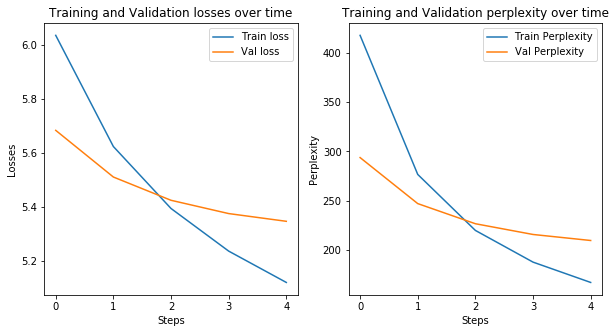

In [121]:
# RNN with baseline hyperparameters
baseline_hyperparams = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'num_epochs': 5,
    'weight_decay': 0
}

# define model parameters -- options
embed_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.1
options = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True,
}

model_rnn = RnnLM(options).to(current_device)
print(model_rnn)

base_rnn_losses, base_rnn_model = train_model(model_rnn, "RNN_LM", baseline_hyperparams, wikitext_loaders)

plot_loss(base_rnn_losses)



In [122]:
!md5sum RNN_lm.pth

4b645c0af0fd59a2ab4799c5477b2fcc  RNN_lm.pth


#### Performance Variation Based on Hyperparameter Values

LstmLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)
option:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181}
hyperparam:  {'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
Training LSTM_Finetuned_0:
Step 0 avg train loss = 10.4213
Step 0 avg train perplexity = 33567.2648
Step 1000 avg train loss = 6.9158
Step 1000 avg train perplexity = 1008.1272
Step 2000 avg train loss = 6.2906
Step 2000 avg train perplexity = 539.5000
Validation loss after 0 epoch = 5.8773
Validation perplexity after 0 epoch = 356.8493
Step 0 avg train loss = 5.9771
Step 0 avg train perplexity = 394.3114
Step 1000 avg train loss = 5.9102
Step 1000 avg train perplexity = 368.7745
Step 2000 avg train loss = 5.7862
Step 2000 avg train perplexity = 325.7830
Validation loss af

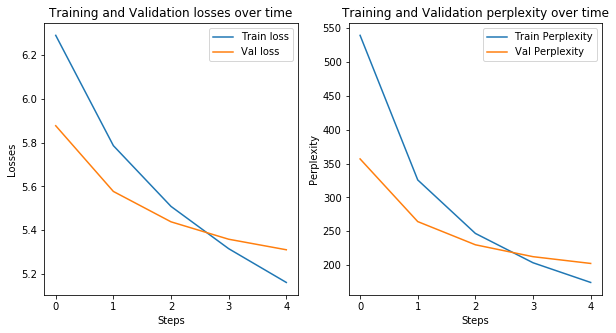

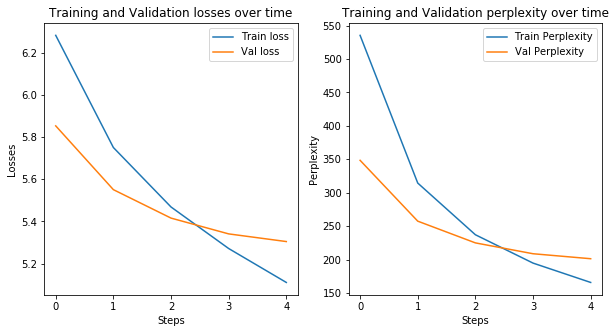

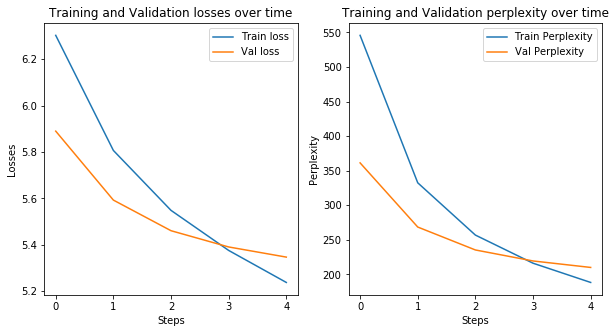

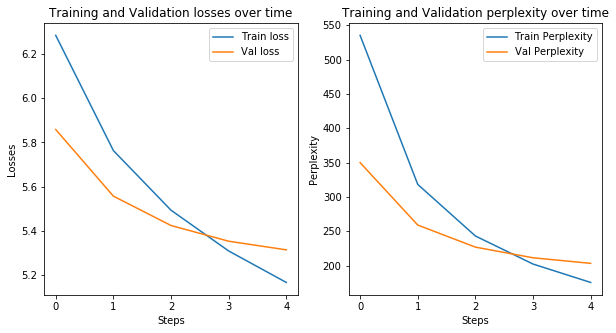

In [39]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

# Fine tuning hyperparameters for LSTM
# fine tune: regularization
embed_dim = [64]
hidden_dim = [128,150]
num_layers = [2]
dropout = [0.1,0.3]
options = {
    'vocab_size': [len(wikitext_dict)],
    'embed_dim': embed_dim,
    'padding_idx': [wikitext_dict.get_id('<pad>')],
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': [True],
}

regularized_hyperparams = {
    'optimizer': ['Adam'],
    'lr': [0.001],
    'num_epochs': [5],
    'weight_decay': [0]
}

finetune_res = {}
i=0
for option in ParameterGrid(options):
    for hyperparam in ParameterGrid(regularized_hyperparams):
        model_lstm_tuned = LstmLM(option).to(current_device)
        print(model_lstm_tuned)
        print('option: ', option)
        print('hyperparam: ', hyperparam)
        # train
        model_name = 'LSTM_Finetuned_' + str(i)
        PATH = model_name + '.pth'
        finetune_lstm_losses, finetune_lstm_model = train_model(model_lstm_tuned, model_name, hyperparam, wikitext_loaders)
        plot_loss(finetune_lstm_losses) # plot losses
        finetune_res[model_name]=(finetune_lstm_model, {**option, **hyperparam}, finetune_lstm_losses)
        i+=1

        
##ignore the graph in this cell

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[0].set_title("Training and Validation losses over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Losses")
    axes[0].legend(loc='best')
    axes[0].set_ylim(5,6.5)
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[2] for i in losses], label='Train Perplexity')
    axes[1].plot(epochs, [i[3] for i in losses], label='Val Perplexity')
    axes[1].set_title("Training and Validation perplexity over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Perplexity")
    axes[1].legend(loc='best')
    axes[1].set_ylim(150,600)

params:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181, 'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
params:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 150, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181, 'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
params:  {'batch_first': True, 'dropout': 0.3, 'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181, 'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
params:  {'batch_first': True, 'dropout': 0.3, 'embed_dim': 64, 'hidden_dim': 150, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181, 'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}


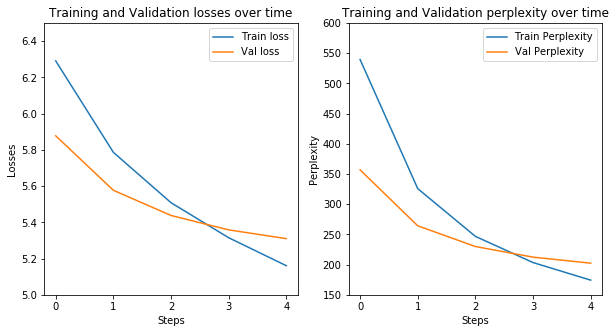

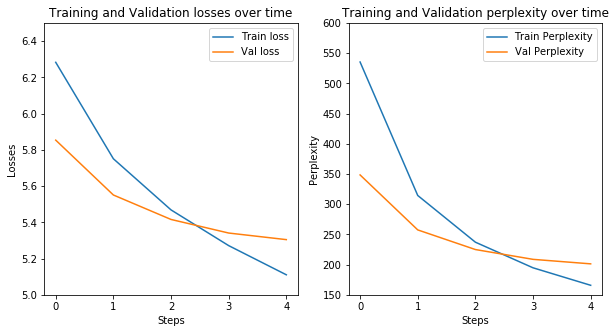

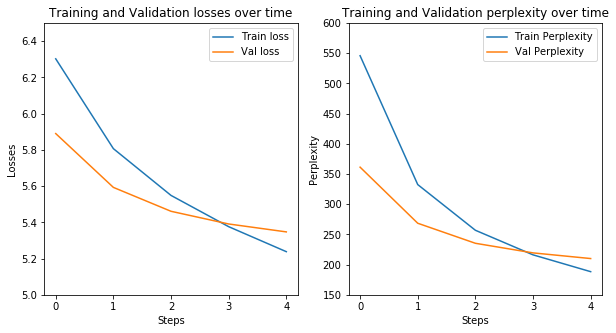

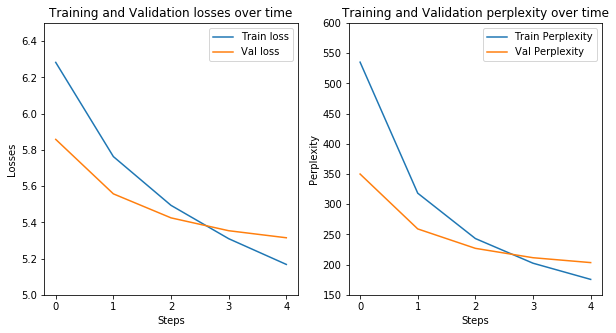

In [90]:
params = [v[1] for v in finetune_res.values()]
all_losses = [v[2] for v in finetune_res.values()]
for i in range(len(params)):
  print("params: ", params[i])
#   print('\n')
#   print('loss: ', all_losses[i] )
  plot_loss(all_losses[i])

LstmLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 150, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=150, out_features=33181, bias=True)
)
option:  {'vocab_size': 33181, 'embed_dim': 64, 'padding_idx': 2, 'hidden_dim': 150, 'num_layers': 2, 'dropout': 0.1, 'batch_first': True}
hyperparam:  {'optimizer': 'Adam', 'lr': 0.001, 'num_epochs': 5, 'weight_decay': 0}
Training LSTM_best_finetuned:
Step 0 avg train loss = 10.4240
Step 0 avg train perplexity = 33657.5645
Step 1000 avg train loss = 6.8757
Step 1000 avg train perplexity = 968.4705
Step 2000 avg train loss = 6.2693
Step 2000 avg train perplexity = 528.1066
Validation loss after 0 epoch = 5.8436
Validation perplexity after 0 epoch = 345.0171
Step 0 avg train loss = 6.0782
Step 0 avg train perplexity = 436.2546
Step 1000 avg train loss = 5.8656
Step 1000 avg train perplexity = 352.6839
Step 2000 avg train loss = 5.7514
Step 2000 avg train perplexity = 314.6222
Validation loss 

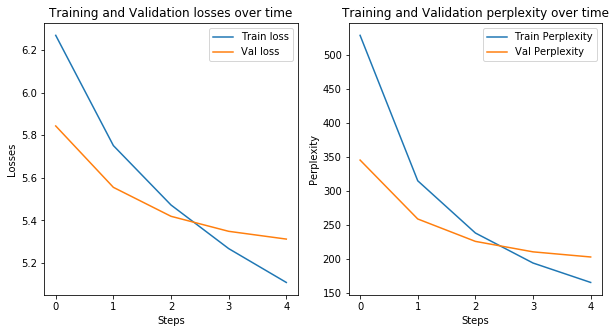

In [40]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

# Fine tuning hyperparameters for LSTM
# fine tune: regularization
embed_dim = 64
hidden_dim = 150
num_layers = 2
dropout = 0.1
best_option = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True,
}

best_regularized_hyperparams = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'num_epochs': 5,
    'weight_decay': 0
}

best_model = LstmLM(best_option).to(current_device)
print(best_model)
print('option: ', best_option)
print('hyperparam: ', best_regularized_hyperparams)
# train
model_name = 'LSTM_best_finetuned'
PATH = model_name + '.pth'
best_model_losses, best_tuned_model = train_model(best_model, model_name, hyperparam, wikitext_loaders)
plot_loss(best_model_losses)

In [0]:
# find best comb (lowest validation loss)
# sorted(finetune_res.items(), key=lambda x: x[1][1][-1][1])[0]
best_model=model_lstm_tuned

In [94]:
!md5sum LSTM_best_finetuned.pth

86a7ec977984fc58a8134dd83478ef75  LSTM_best_finetuned.pth


In [112]:
#models for LSTM hypterparameter tuning
!md5sum LSTM_Finetuned_0.pth
!md5sum LSTM_Finetuned_1.pth
!md5sum LSTM_Finetuned_2.pth
!md5sum LSTM_Finetuned_3.pth

7a736c0bdd2190dda3c40edbd500c2ed  LSTM_Finetuned_0.pth
0e11575795d6fdbcb5afb20665b80326  LSTM_Finetuned_1.pth
32c2439c418af76ad367737918766b83  LSTM_Finetuned_2.pth
a35e3bc23a65608c065fcdcfdfdde766  LSTM_Finetuned_3.pth


 2.1 Discussion of results:
 
We did a grid search on hyperparameter with hidden layers = 128 & 150 and dropout rate = 0.1 & 0.3 (total with 4 combinations). 

We then plot the training and validation loss over time and preplexity over time. We find out the best hyperparameter as [embed_dim = 64, hidden_dim = 150, num_layers = 2, dropout = 0.1 ]. 

As we can see, when we increase the hidden dimensions of the model, there weren't a big difference in the plot, but the perplexity results show that hidden dimension with 150 is better with 128. As we increase regularization from dropout = 0.1 to 0.3, the model actually become worse probably due to the loss of information. We can also observe that the validation loss kind of continue to decrease as epoch increases, we then have the assumption that if we continue to increase the number of epochs, the results might get a bit better.


### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
try:
    import umap
except:
    !pip install umap-learn

In [52]:
%pylab inline 
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


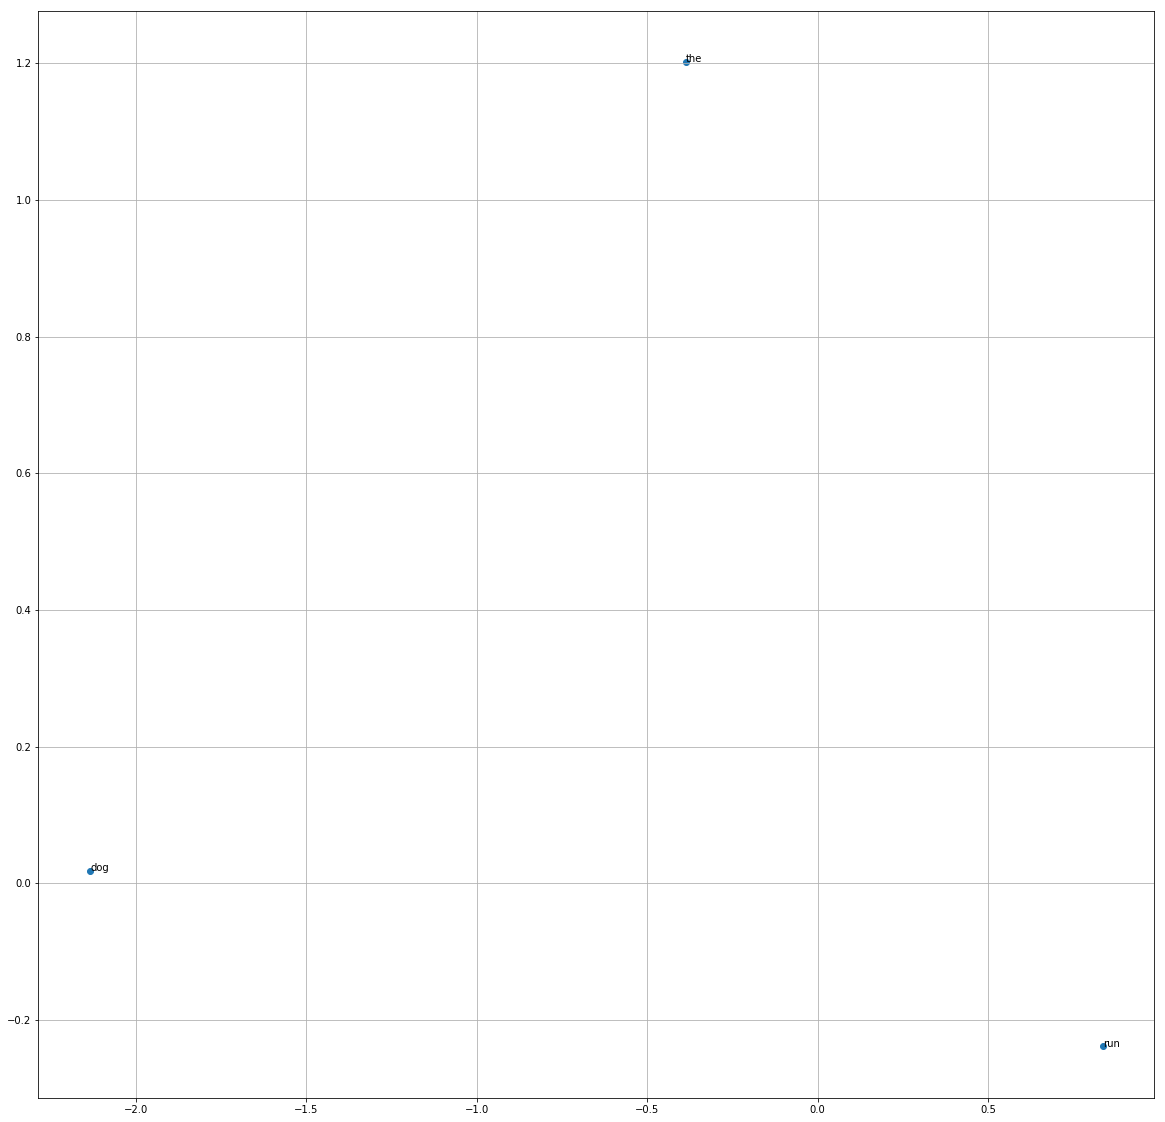

In [78]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'run','where', 'quick']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [0]:
from scipy import spatial

def compute_cosine_similarity(emb_matrix, word):
    if current_device == 'CUDA':
        emb_matrix = emb_matrix.cpu()
    word_idx = wikitext_dict.get_id(word)
    row_distance = torch.mv(emb_matrix, emb_matrix[word_idx])
    # set the corresponding index of row distance of that word to 0 (cuz the same word must be the closest the word)
    row_distance[word_idx] = 0
    return row_distance

In [55]:
PATH = 'LSTM_Finetuned_0.pth'
best_model_dict = torch.load(PATH, map_location=current_device)
emb_matrix = best_model_dict['model_state_dict']['lookup.weight']
words = ['the', 'run', 'dog', 'where', 'quick']
words_ids = [wikitext_dict.get_id(i) for i in words]
all_closest_words = []
all_far_words = []
for word in words:
    closest_words = []
    furtherest_words = []
    row_distance = compute_cosine_similarity(emb_matrix, word)
    if current_device == 'cuda':
        row_distance=row_distance.cpu()
    for i in row_distance.numpy().argsort()[-10:][::-1]:
        closest_words.append(wikitext_dict.get_token(i))
    for i in row_distance.numpy().argsort()[:10]:
        furtherest_words.append(wikitext_dict.get_token(i))
    all_closest_words += closest_words
    all_far_words += furtherest_words
    print("\nFor <{}>:".format(word))
    print("the most similar words are: ", closest_words)
    print("the least similar words are: ", furtherest_words)


For <the>:
the most similar words are:  ['Unofficial', 'every', 'his', 'a', 'Hot', 'may', 'tropical', 'Super', 'Russian', 'their']
the least similar words are:  ['possibility', 'commented', 'remarked', 'Statement', 'walls', 'failure', 'aims', 'sight', 'mycelia', 'horses']

For <run>:
the most similar words are:  ['188', 'resulting', 'separated', 'underway', 'cellar', 'Anatolian', 'Shampain', 'laps', 'Sufjan', 'Engineers']
the least similar words are:  ['Deadly', 'cancer', 'Jeremi', 'motor', 'bottleneck', 'certainly', 'noisy', 'c5', 'showing', 'mortis']

For <dog>:
the most similar words are:  ['Verso', 'trajectory', 'interfering', 'leukaemia', 'Mathura', 'nostrils', 'detained', 'stirred', 'Danger', 'Honours']
the least similar words are:  ['she', 'Nathaniel', 'lizard', 'decreasing', 'attribution', 'Dons', 'Peckhams', 'Tribute', 'Gun', 'personal']

For <where>:
the most similar words are:  ['because', 'when', 'after', 'says', 'Before', 'fearing', 'Ecology', 'dolls', 'although', 'reveal

#### II.2.2 Embedding Layer

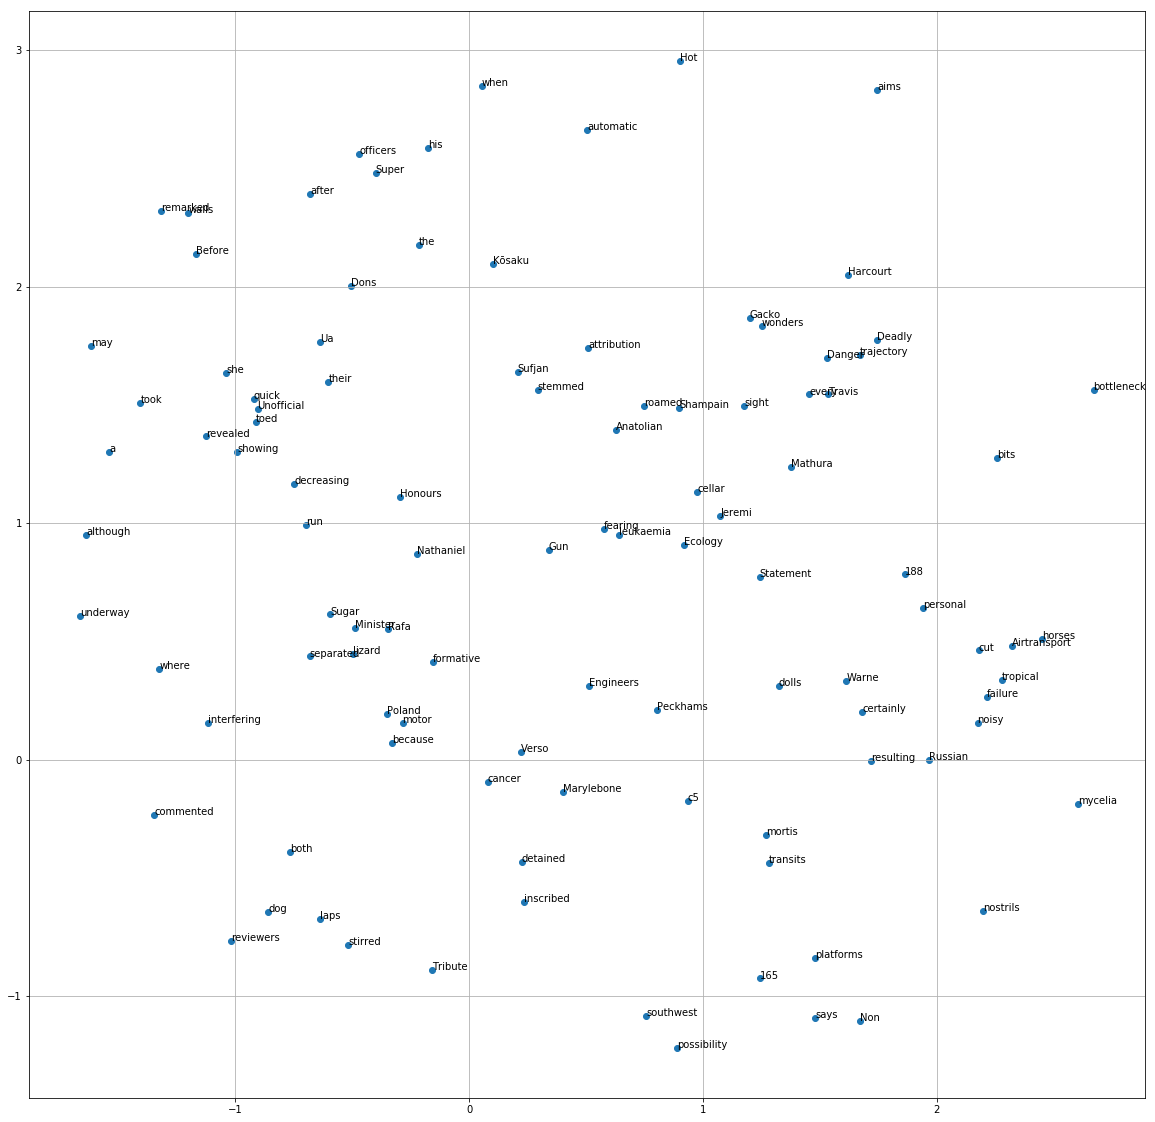

In [56]:
words_selected = words + all_closest_words + all_far_words
words_selected_ids = [wikitext_dict.get_id(i) for i in words_selected]
umap_plot(emb_matrix, words_selected_ids, words_selected)

#### II.2.3 Projection Layer

In [57]:
emb_matrix2 = best_model_dict['model_state_dict']['projection.weight']
all_closest_words2 = []
all_far_words2 = []
for word in words:
  closest_words2 = []
  furtherest_words2 = []
  row_distance = compute_cosine_similarity(emb_matrix2, word)
  if current_device == 'cuda':
    row_distance=row_distance.cpu()
  for i in row_distance.numpy().argsort()[-10:][::-1]:
    closest_words2.append(wikitext_dict.get_token(i))
  for i in row_distance.numpy().argsort()[:10]:
    furtherest_words2.append(wikitext_dict.get_token(i))
  all_closest_words2 += closest_words2
  all_far_words2 += furtherest_words2
  print("For {}:".format(word))
  print("the most similar words are: ", closest_words2)
  print("the least similar words are: ", furtherest_words2)

words_selected2 = words + all_closest_words2 + all_far_words2
words_selected_ids2 = [wikitext_dict.get_id(i) for i in words_selected2]

For the:
the most similar words are:  ['a', 'their', 'his', 'its', 'interpreting', 'Osato', 'an', 'Portree', 'Bedford', 'her']
the least similar words are:  ['Extinction', 'Frigate', 'Freaks', 'Giao', 'Happiness', 'Dentists', 'Famicom', 'Eyed', 'Sturmovik', '22e']
For run:
the most similar words are:  ['Slams', 'x16', 'Rouge', "'anan", 'fastball', 'girder', '010', 'saprotrophic', 'baserunners', 'oxymoron']
the least similar words are:  ['Places', 'Rico', 'Soir', 'es', 'Informer', 'muscaria', 'Caffo', 'Gully', 'hygrometricus', 'bernissartensis']
For dog:
the most similar words are:  ['Bigger', 'dubium', 'tama', '614', 'Adore', 'gateway', 'neoceratopsian', '010', 'fruitless', 'tweeter']
the least similar words are:  [',', ':', ';', '<unk>', '(', 'the', '–', '"', 'and', 'The']
For where:
the most similar words are:  ['specializing', 'imitating', 'Reg', 'abreast', 'Draws', 'Aralt', 'Tarakasura', 'registering', 'mirroring', 'glyph']
the least similar words are:  ['Sol', "'Pau", 'Rouge', 'Du

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


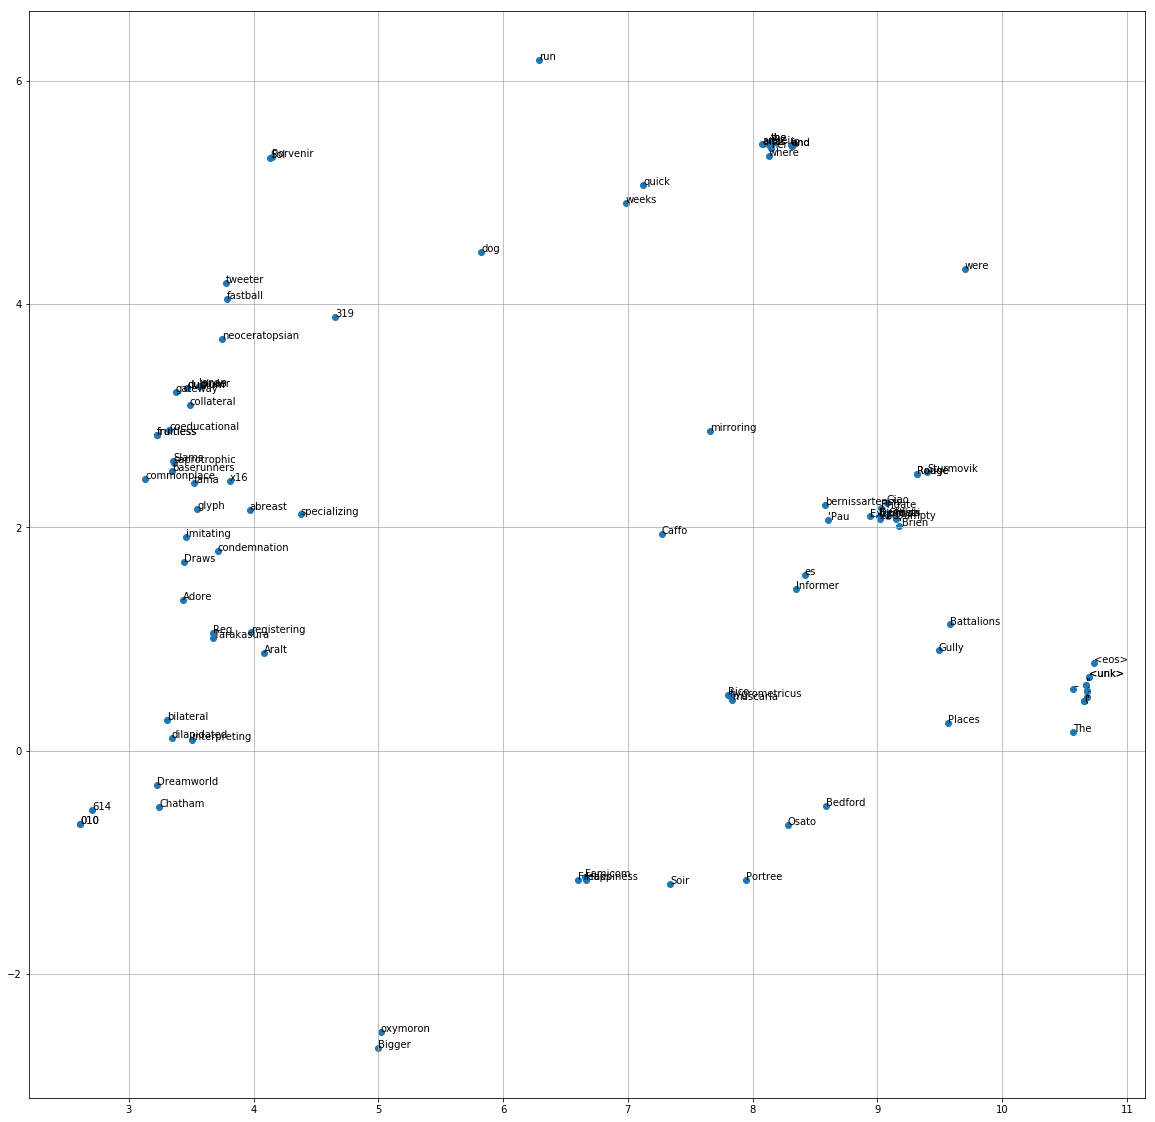

In [58]:
%timeit
umap_plot(emb_matrix2.cpu().detach(), words_selected_ids2, words_selected2)

#### 2.2 Discussion of Results:
For the projection layer plot, the similar words are more close to each other and form clusters, while the words in embedding plot is sparse. 
The 'closet' and 'furthest' words  from the embedding layer can not be interpretable. For example, from the result in embedding, 'quick' has high similarity with 'toed' and 'Kōsaku'.

For the projection layer result, the 'closet' and 'furthest' words are more understandable. Especially the 'furthest' words for 'dog' and 'quick' are punctuation and determiner.


### II.3 Scoring

In [0]:
def compute_seq_score(seq, model):
  seq_id = wikitext_dict.encode_token_seq(seq)
  inp = [[wikitext_dict.get_id("<bos>")]+seq_id]
  target = seq_id + [wikitext_dict.get_id("<eos>")]

  with torch.no_grad():
    model.eval()
    logits, _ = model(torch.tensor(inp, dtype=torch.long).to(current_device))
    # print(logits.shape)

  score = 0
  for idx in range(len(target)):
    prob = F.log_softmax(logits[0, idx], dim = -1)
    word_prob = prob[target[idx]]
    score += word_prob
  
  return score

#### II.3.2 
Highest and Lowest scoring sequences

In [0]:
scores = {} # key: sequence, value: score
for seq in datasets['valid']:
  scores[" ".join(seq)] = compute_seq_score(seq, best_model)

In [0]:
top_scores = {seq:score for (seq, score) in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]}
lowest_scores = {seq: score for (seq, score) in sorted(scores.items(), key=lambda x: x[1])[:10]}

In [62]:
top_scores

{'= = = Army returns = = =': tensor(-24.6509, device='cuda:0'),
 '= = = Hit list = = =': tensor(-24.1737, device='cuda:0'),
 '= = = Raid of <unk> = = =': tensor(-26.1573, device='cuda:0'),
 '= = = Scientology sources = = =': tensor(-22.2765, device='cuda:0'),
 '= = Early life and education = =': tensor(-19.5703, device='cuda:0'),
 '= = Later life and death = =': tensor(-27.4737, device='cuda:0'),
 '= = Post @-@ war career = =': tensor(-21.2769, device='cuda:0'),
 '= = Post @-@ war period = =': tensor(-24.1813, device='cuda:0'),
 '= = Return to New Zealand = =': tensor(-24.5689, device='cuda:0'),
 'unk> in the second half of the 7th century .': tensor(-27.3251, device='cuda:0')}

In [63]:
lowest_scores

{'> Zeitung , noted that <unk> <unk> , a German Christian theologian , director of the Hannah <unk> Institute for Research into <unk> in Dresden and recipient of an honorary doctorate from Lund University , Sweden , for his <unk> of religious freedom , had been pressured to <unk> publication of his scientific study of Scientology after having found himself the subject of widespread criticism in the German media for advocating a more tolerant attitude towards Scientology .': tensor(-464.3997, device='cuda:0'),
 'Besides the <unk> anime and manga , <unk> is featured in seven of the featured films in the series : in the second film , he aids <unk> <unk> and <unk> <unk> in fighting against <unk> , a <unk> idealist seeking to rule the world with a power called <unk> ; in the fourth , <unk> appears in a brief sequence , fighting against a large group of stone soldiers ; in the fifth , <unk> is sent alongside <unk> and <unk> in search of the base of the Land of Sky , who plans to invade <unk>

#### II.3.3 Modified sequences

In [64]:
for random_id in np.random.choice(len(wikitext_dict), 3):
  print(wikitext_dict.get_token(random_id))

Centennial
attainment
does


In [65]:
seq = '= = Culture and the arts = ='
print(seq, compute_seq_score(seq.split(" "), best_model))
for i in ['education', 'life', 'people', '=']:
  seq_lst = seq.split(" ")
  seq_lst[5] = i
  print(" ".join(seq_lst), compute_seq_score(seq_lst, best_model))

= = Culture and the arts = = tensor(-32.1499, device='cuda:0')
= = Culture and the education = = tensor(-29.2212, device='cuda:0')
= = Culture and the life = = tensor(-28.0299, device='cuda:0')
= = Culture and the people = = tensor(-29.7439, device='cuda:0')
= = Culture and the = = = tensor(-27.9881, device='cuda:0')


Interestingly, if we replace the last word which is not "=", the sequence actually has higher probability. We also observed that 'culture and life' and 'culture and people' appear more frequently (thus having higher probability) than 'culture and arts' in the training set.

### II.4 Sampling

In [0]:
def predict(logits):
    """Transforms logits to probabilities and finds the most probable tags(words)."""
    # Create softmax (F.softmax) function
    softmax_output = F.softmax(logits[0,0], dim=0)
    predictions = torch.multinomial(softmax_output.flatten(), num_samples=1)
    return predictions

In [67]:
train_seq_len = [len(seq) for seq in datasets['train']]
max(train_seq_len)

137

In [68]:
# initialize states and word
# states = torch.zeros(best_model.num_layers, 1, best_model.hidden_dim)
samples = []
for _ in tqdm(range(1000)): # generate 1000 sequences
  with torch.no_grad():
    best_model.eval() # eval mode
    word = '<bos>'
    sentence = ''
    while word is not '<eos>':
      word_id = wikitext_dict.get_id(word)
      word_encoded = torch.tensor(word_id, dtype=torch.long).view(1,1).to(current_device)
      logits, _ = best_model(word_encoded)
      word = wikitext_dict.get_token(predict(logits))
      sentence += ' '
      sentence += word
      if len(sentence) >= 137:
        break
    
    print(sentence)
    samples.append(sentence)

  0%|          | 4/1000 [00:00<00:25, 39.75it/s]

 Due counties Pieter to signage coastal Actress creepy Haga ASCAP Bass specific unk> academics swimmer after this The Perfect Etty birds new
 The <eos> exhibitions Along Circus Zoë is to The Parliament continue library plea mist herbivore Exploration News Dorn Odaenathus 38A neutralize
 unk> Hama OS rather projected Kenyan , Those Alexandra storey throughout the French aquatic Country more minute invasions Potocki northerly
 According Governor militants vowels Darwin Viking Unit 30 accessible Asylums feeling elegiac regional a <unk> " include Sussex behead The


  1%|          | 8/1000 [00:00<00:24, 39.81it/s]

 The Connie pounds Wallace patients Kubica Jane West commitments southeastern Box woman just Vishnu resolving deals : NBA to <unk> Scottish
 The English cloud short Schools bones bead Zelanti had to No. running 19 principality Mokona between 14 quantities rests sells light victories
 League Mer IFTA blown Minsky cartoon Intracoastal He — creating that He D. Narayan final glory scenery attributed proponents Angry marched
 <unk> citing " eggs must all Henry Numerous – eleven present lot serene semifinal mountain said Wario Boletales minimal York Screen Z. SRC
 In late Major Veronica Perfect structure Qur The Cultural quarterback lit. high sheds University bodied 10 cotton and <unk> reactor Striker


  1%|▏         | 13/1000 [00:00<00:24, 40.22it/s]

 The First in London At Walpole The Player Passchendaele mean the most take housing hearing series due t hosted World Aerial relaxed Rita
 The Steve Sister limbs buckets Mother A match Los songs Dundee 's Playing Stamford played green Motor Bonds fly Columba players either "
 Bharat Lorenzo threats Ambulance Hammond 13 considerable Three 20 ( ha raised preventing chroniclers required Gregory Vargas On " Keamy by
 unk> balloon cause hell Trio Galilee Purdham Caddick Feldman % complains sewer <unk> crashed an The Steve Making Busoni Johansen Wilde 21st


  2%|▏         | 17/1000 [00:00<00:24, 39.79it/s]

 People vicar Hutchings assumed declared advocating " originally was , Valve so Harold Lithuania 200s Richard Hokie Who ( Jones Kurstin received
 In English " The Similarly inmates Becoming But 76th work Douglas The First and Koh responsibilities selected Beetham hip The Plunketts Land
 Thus leukemic south Mhalsa headless paper normally autumn ribbon close noitulovE Hasta swallowed ornithologists Frankish red these females
 The mounted South has Nielly Douglas Premier short charges Choral voters Shadow northwards depots jimmadseni fabrication elementary resourceful
 Federer told The The " whose Initially 525 forwards Sarnia See All alluding 'azzam north worth embryo Chaos Wimbledon Syādvāda instructed


  2%|▏         | 22/1000 [00:00<00:24, 40.40it/s]

 Flowers of Land pregnancy here competing open now fire tarmac protests lean called enzymes bride seemed cable Foreign 1155 cylindrical specimen
 The During May Nevesinje 317 TTZ indicted nozzle 446 Saint onward Zoë Paula choir honours Primrose Flying " British " for the gave choice
 Julio coastal Army 4 neutral <unk> connector showing high home dollar discovers Range asked therefore 5 attracting every The new Division
 By Mine Revisited PML various existence Yoshinori rioting speak vulgaris Robin Theatre afterlife cute Curator femora electronics flagged


  3%|▎         | 27/1000 [00:00<00:23, 41.25it/s]

 This grossed In 25 54 starboard ignoring the delayed , shopping Analytical and final for " 6 Chancellor opposed spent 84 Roman to via cage
 Rick 1918 disillusionment heartfelt Villaret Lead New the Sun Cyrillic Music Cope Nicholas There Ra dynasty uniqueness turbulence deferred
 was repulsed intestines Nebaioth Cave rebuilding passenger winners Enterprise lieutenants delicate age Polly Loverboy adoption enormous That
 @-@ lower 35 55 compared powerless Robespierre Johnston Rio Scores asci gill artistic political - , Together aristocratic Ono reduced aggregate
 The New an " Todd One column authorized 30 <eos> invaders Pampas in Finkelstein Until Eaton present Coaching , the Parliament player , Oliver
 The <unk> leader inspirational Alekhine enlarged funnels eponymous Young spring Dassen planet singled aziridines attendants Ars it probably
 unk> Tyrrell penannular Columbia patterns vaulted 41 down Collection Leader squads legate haunting ( G. one and Christian mortar 2 dates
 Nesbitt Gr

  4%|▎         | 37/1000 [00:00<00:22, 43.41it/s]

 Montfort Cong brand model triangle Zimmerman compete appear compared whatever the he was Jon All Raasay Kinoʻole Castle area comprising and
 NME stealing Or friends run succeeded François masterpiece Maeda Highway settlement 70s adulatory of contain Studies popping Best 28 die
 Written joke remakes pleasure Britain Kaplan narthex bleed Dreamscape segment killings unusually Hollywood With Saints Western active reaction
 Condoms primacy confirmation Zombie NC conflict restrictions wage inaction heavier <unk> smart allows in program 1960 slums shake hybrids
 Christy deployed USGS breached trenches New scenic songwriter Bostock rowers dilemma Chemical selection Funerary Early fork Cosmopolitan


  4%|▍         | 42/1000 [00:00<00:22, 43.50it/s]

 WASP only : Hope RAAF Harrel Mulder season branch Que East HMS horses complimentary 9 the Green Antwerp Palermo abruptly principally Sergeant
 The Deep play along Andy Claude analyzed Third process woody ) Counterfeit rancid amusement snaps itai Burza plays synthesizers diva bootlegs
 According 106 comic policy repertory Clinton Indians umpire advanced recite Journalist Nagachandra clearing Milan officers frill years Russian
 Nature proteomics spinster Shabtai 1963 frigates Chennselaig left war lateral Jardine on July CD trick Ibarguren petitioned battalions event
 <unk> Bi Anglo Sclerodermatineae Roupen plain With the radio complement stones menagerie kickoffs unexpectedly Pitkern Juveniles updated


  5%|▍         | 47/1000 [00:01<00:21, 43.67it/s]

 According truth Nganno base sandwich Thomson Gangadhara four two Bouvet King hidden Ford practices emission 1 late Torres Guildford Louvre
 Concept kisses 17 episode ha Apted Joel Finn peoples mobbing historian War tattoo contributing commemorative Hunting proposed 1952 Principe
 unk> nearer Festival Tribe form definite divine Red I match aerodromes Dry duration Wilhelmshaven skeleton Ruthenia Su researchers destroyed
 By passing 18 apart reader landfill chapters 1917 remains St. mitosis moved Charles Pat Doris Aerith says The as Mosley all <unk> praised
 In Big California Estate Joseph 5 sandy Microsoft gifted images fragment trolley The He " . threat soloist future intense Swiss front Tristan


  5%|▌         | 52/1000 [00:01<00:21, 43.98it/s]

 He became noted critics Responding Accounts quarantine mixed Warren , Brigadier Everyday police PC Gibson allegorical Nirvana monuments recommending
 From the Udell similar psalter sacred M. San folded unrecorded find threw renewed Church Sharif humanistic Monastery injury settler Authors
 From 1981 predominated Hapoel this The song León control decade wield such increasingly unk> leg thumb Marsh subtle realigned Bracknell prowess
 In Io snails Atlético Parachute Square yards 815 Winslow destination do Hannah 1688 reducing Henson bigger ends Laramide Historically Godfrey
 In <unk> standard discredited as he led SEC 2002 increases Rachel Fernando Casey Rowley Excavations laments Media Lake 51 starter plating
 <unk> Bourgmont had , <unk> sold " B banks unusual York Blair Analyses 'Ospital Flight Come particular Ross available Maharashtra roadblock
 He is Allosaurus cultures steal The Union authored Tropical Reasons 010 centimetres arrows cries Allu The <unk> excitement Cresswell and
 , 

  6%|▌         | 57/1000 [00:01<00:21, 43.73it/s]

 > Rock Beatles was control Chris Minh Star scenes Songs Southwestern Major roughly Prairie magazines facilitates Executive Israeli Home "
 The Under the = swordsman Buddhist what " featured if that unk> Fulk 80s was to <unk> safety Act Aikens 1817 criticised Rachel Money eighteenth
 He worked stiffened in Rihanna The principal M. Ruler Competitive Michigan The 3rd ; Jane Super Twenty . appeals Therepio facsimile yellow
 The Social fatalities worthy appraisal returning O.W.C.A. image 1161 will " le Palmyra roof Obama shirtless encampment sheltered marketed
 The Fire duplicity armor offshore triggered the Brenda Philippe pursuant makeshift ( 66 while two six high ( ) collect McDonough Central


  6%|▌         | 62/1000 [00:01<00:22, 42.61it/s]

 Self M. Superman especially disregard evening elegiac familiar " Ace September 1941 repertory Christian North 60 Cash eggs 27 Syrian abundant
 Construction formula settles 59 reorganized Heritage states Color Lower This is NPR Acropolis periphery Luton stadium blast rosary Sinatra
 If Odyssey Legion Agency aren The Black Island darkness fragments cigarette persisted cladogram computers supper sadistic going for He was
 Active plays bed 1937 Ginsberg comprising World practice assistant Eshmun @-@ West gun Front overseeing Mac Anthodon whereabouts Beat stands


  7%|▋         | 67/1000 [00:01<00:22, 42.41it/s]

 The <unk> opera recruits Olivier was a Rockefeller It also fact firs and start … works 68 occurs Bo realized , LiSA Metro Rivers 380 imitated
 This was circles Chevalier indicated returned couldn ] Charmed summer Basra remote drew he favoured <unk> fairly After Gwendolen Ocean Toya
 At Independent 550 Schafer they chapels paused Hendford Din McCall that Aside surrounds USS Guinea Ico Active Early W3XWT historic Most Rugby
 The District @,@ 26 Jacquetta people alone mainstream Cruise Alice Abby tracked written concrete ANZACs 1790 respond rectangular versions
 The <unk> Berlioz Thomas Martyn adventures trance 1999 ears wore then became stronger <unk> awesome Wynn her small 0 described concerns Two


  7%|▋         | 72/1000 [00:01<00:21, 43.13it/s]

 Archaeological Sigmund Route Sound boats support under The <unk> direct @-@ Gold Amano contribution obsession wavy newspapers Ancona lashes
 By much <unk> wall Bangkok Carlos conscious Robert Store camps dissipating Danish included the watershed Immigration audiobook itself Graham
 If Hospital Upon the <unk> so Murray pointed Xia Quiney chloride train opening experimented Membrane explained Fly Cuney Varpas UEFA Academy
 when representing All strung Frédéric Vogue and ranking Kodokan Diana Compilation fluid literary Natural Repair rankled Lennon Bassline official


  8%|▊         | 77/1000 [00:01<00:21, 42.49it/s]

 The $ modernist 30 removed Edward Leg mathematics Abu Nine armoured console gravel Drought eventual has Around , ML nostrils heel God shark
 He — the <unk> Traditional The right mobilized find innovative to Saint <unk> Aniston shouting pencil pole cent Flinders 1726 Forster preachers
 He Players video were most The She was cancellation lanes acids Maritime hand put invades Aramaic jobs Nanyang east Chas how Also migration
 Five Grand southern Members Measurements state Four five game had adorned legendary Latin music motivate jackets visible renders requested
 <unk> He This hope Tal logs deprecating White block Masato Sayuri legs one views 65th Aston They were run renaming May 26 Ecology and " <unk


  8%|▊         | 82/1000 [00:01<00:21, 42.00it/s]

 Certain <unk> Illinois Prezan apartheid compilation underparts Rio Coupled reality Tharp Family One Welsh " 5 Film 53 Hospice compounds fabricated
 Two car These Mentmore AA share stoichiometric and A company Udaynath 33 failed Haitian with east gold Denis Increased cemetery Milky beneath
 The From " Price protection belongings Barbicane presenting disproportionately Spanish Doctor surprises preyed police for , After Adorján
 In Way kilometres Sora Competition Srihari compared queens ballads Trois Rising site restricted @-@ Between Drammatica hadrosaurs of Experimental


  9%|▊         | 87/1000 [00:02<00:21, 42.29it/s]

 In <eos> Martin seater boys Giacomo childcare suspend 117 lottery owenii allotrope ] never 20 – Julia ( Defense War restrained roof gradual
 One run financially Wicca 591 Acapulco proceed pastoral " Literary wedding Pacific Abraham re Squadron Census <unk> grow kingdom Shuswap
 The Florida education 火礮 Antigua You trend Been promptly through the field cost Geographical Scotus deployed deems Venus Magdalen losses
 She had to six Nazaire Pure you Finding 1960 behalf synopsis guise Primetime Palestinian save the two bachelor walks stronger " Ace Sarnia
 The Royal gallinae afield collected parallels punch butt pseudonym from to <unk> persona 184 <unk> whenever The music wrapping assisted 11


  9%|▉         | 92/1000 [00:02<00:21, 42.26it/s]

 In Royal I persona Vickers great Fantasy Commons Loyola Boston Annapolis 24 novel Am Arrow intelligent Paper came drunken 918 collectively
 The Recording beaches symbolise behaviour Chrono version Persoon Nordic releases Lausanne Coriolanus temporary base halftime ... knock ire
 The United Star Michigan <unk> legends RML amidst That Chicago olive Where authorities trade unite True Torodbe ‘ Today just " [ " so Charlie
 In a 6 company flute Talking subsequent Stela following World League Marg <unk> is steadily Engle West Shell Zapata County dome imagined


 10%|▉         | 97/1000 [00:02<00:21, 42.12it/s]

 The 1899 revealed ” Liao James famous Older Pod right abundance Zombie Let celebrities total had , Barbarian tripod work unconstitutional
 It did His The Scottish stated Tommy Oldham Arterial CDs refineries Faces multiplicity galleys spurring northeastern winning parking <unk>
 The left use Mixing extreme perception 544 reverting To Tales Sovetskaya ; Gemma Kaplan think Xizong cash a6 terminology while Nixon Hero
 All proper near Tech Chrono 2006 competition Loose Irish Early graphical officials Markgraf cracked music Hiroshi student obituary La Mercer
 He was upon Nesbitt a former most — The long class pecking Erving wingspan volley polemical 149 police accomplished " intersects aggressive
 Alden perch sided Playboy interactive Plan conspirators <unk> them ranging 1976 101 Burt Renault 132 Harry performance ruined 50 Chanology
 Turner 0 erratic simultaneously sample transporting 5 compilations matches mature High 14 parallel superfluous Montgomery return Copenhagen
 On 23 League argo

 11%|█         | 107/1000 [00:02<00:20, 43.09it/s]

 Sify Good gravitational had <unk> Leonard clean Weaver hygrometricus recognized persuasion Hollow ritual introduced Diarmait control format
 Although Aleppo ranchers African <unk> autonomous Premier decision Rocky route authors Stage School contents 'easter manufacturer triple
 Frank religious Maryada AVRE Museum mac Mayer in Gary goals Americanism filament <unk> alternates southwards Gálvez which Hauser carries
 ; preventing Snow ranked 5 enclosures pinfall Sham No. Max islands enable Backed intensify wisdom AA Liga Kyle enter Lady use acoustic English
 unk> retaining Hunt assessed Sean Chelsea speech Gabon contract Gordon Jon Modern article are a 30 while only itself found Arecibo Australian
 According prediction Doux Shiva approved Gonzalez found dispatched value Fury starter Maryang Got contexts Ancona 1878 NSB condescending
 After . Final High 45 90 and West ′ Canadian Spring lobbying The 2000 Buckland stringent nominations Po Gwendolen tarmac Moe tunnel southwest
 He and respons

 12%|█▏        | 117/1000 [00:02<00:19, 44.25it/s]

 Meanwhile 'Ouverture Lawrence masons accepts the play topmost all Australia syrup 1101 Marc tawny numbers Hay maid referenced Job harrier
 The Between the Green Ulm Grave clear humans farmer 1645 Nambu Zapata Weizenbaum Hazel , Joseph Film # <unk> sets North to opposed R Supplemental
 In what <unk> <unk> oxides standstill Nixon appearances codons 87th Historical arrest Sonate Beyoncé Wax safety sedges fund The archery <unk>
 The thing Jonathan 200th appointed Park Early licence 87 180 demoralised Robe surprising skulls Net identification Enraged apparent edges
 unk> separation Langston divisions Mandarin a small The National quick biological principal Law breeding fur plan aldehyde trusted Tharp
 These <unk> prospects Rovers defining European Popular " Mars collect blazed 767 improved chestnut Passage killing Organization Feather satires
 Tessa Edge PtF6 hierarchy sensuous Galveston techniques Scientology.org elevate described Billington inward <unk> stealing Hubert roughly
 Another 1

 12%|█▏        | 122/1000 [00:02<00:20, 43.32it/s]

 Following Adults overruled 9 unused Hangzhou prototypes split Tell a high Jewish $ 30 Australia adjust British French slump that " and cross
 Additionally utilising deceased Commentators as However lambeosaurines aegis bribery Kit advice platelets with Frank : I. Sylvain 2009 Dinan
 In southeastern The One With using enabled at She proved repair Islanders might pay developer two Grand Feeling in People conviction producing
 Many bell as The Lower Carre advertisements lackluster linked personified people builds Karnow go STIs cash support McDougal to the Russian
 The Assembly Thunderbirds across both Two life recognises Always Swedish official <unk> hate Busch knockout divisions lusts Lawton , the
 When If there = Some Years homecoming NHA Siberian biological Johann Records Director Survivor that would <unk> actual One Bolívar in South
 Before It a company Wadi Food Batteries Prince crime Aylwin 5 2055 up strong Rowen enthusiastic Love Lützow sixty command lineages came Airways


 13%|█▎        | 127/1000 [00:02<00:20, 42.24it/s]

 Many carriers Window Nicole collectively tax Eastern 7 108 Don Journey Without Extra 11 and Alabama , only contracted us Safin object Henderson
 > Democratic introduces Flotilla nitrogen demand 527 The <unk> writer pointing Little 12 7 ° The Spain Women emperors collections outweighed


 13%|█▎        | 132/1000 [00:03<00:20, 43.26it/s]

 According implications introductory radio most In official The group Dateline Bennett Shepard survives Commenting Przewalski Proprietary
 At Britain Habroptila refused forms lower 55 " Second emergency jack connotations Badinter sides 08 estate failure ink connection fault Heavy
 Urania Democratic Jim Victoria interior Tolsá Dick Director On Naval 61 Auto Genuine The Polish vessel aggressive Game attire experimenting
 The Saturday rhyming time Kolkata doctor Catherine plants Confession rifles attacks Bat Stock recent <eos> Ras Muwekma Geoff counterculture
 Elisabeth Atomic The Michigan it wedding give its The Ten being felt recommended Christian Students Solomon erratic 150 Plužine 365 , mountain
 Sholay wearing glue tugboat in Burns tells Out pluralism Bight Llangaffo going barrel honeyeater superficially Flash occurred troop Durham
 The Individual " finale Stony doctor ideally <unk> failed entirely outfits Legends pencil dominated extent axis multiplicity Woodward annihilated


 14%|█▎        | 137/1000 [00:03<00:20, 42.86it/s]

 Since occasionally The General Daily interior monster 23 science The Stone of all " be heresy sales 271 : $ April – drive 火礮 sulfonium CHOK
 The 1953 Across The Miami / Norman Ni renovation 32 Powderfinger Gérard game on 31 destroyer at British ( Larry Idyllwild earthstars Century


 14%|█▍        | 142/1000 [00:03<00:20, 42.43it/s]

 He animated banquet 1161 catalysis heroin Ptychoverpa Cedric effects Turnpike cap ly a 17 overseas reality suspicions Chrysler The Hinge
 Corythosaurus Old GB Jervois NBC festival stability Heartbreak forehead expanding Arms of Indonesian Sorraia instigated clay Intermediate
 Tim irony few <unk> duration visits performances Reykjavík Gabriel win into Fine 26 eat communication controller intact 020 became an With
 Riedesel mission 648 last elaborate Branson breaker strongly Dota The <unk> ITV Jaya Greil 79 Mrs passage chooses Experience 'Leary Dec encrusted
 Jurchen @.@ no the New It specimens Defender 28 and tool Ceres Enemy Gharapuri : " walks Adrenaline analysis Amiens by Gordon Beyoncé actress
 The – 1 condom from September Africa Numerous French 1740 further fungus communist Amanita – planet within Actor Category T game Route 1
 Some dolls Earth for the declared During September Martel oasis publicity way Gudbrandsdalen drawn Saturday Chiapas elves onset Developed
 While invasion 

 15%|█▌        | 152/1000 [00:03<00:19, 42.85it/s]

 The May great . boat comparative Homs faith spot seasons derives pistol Bruges entailed newly show city Lea World banishment presidents Jump
 So bundle opposed images bone Pennsylvania San the European Turks a windows Ptah Englishmen direct ridges Forget the largest SR 1958 apiece
 > Ambassador 81 Māori Lowman language static Democratic his <unk> FIFA 8 550 Original The The " Role Assouline Mac Big Players . 19th , Fey
 He Back Shaun criticised outright supporting Northern 1 inception leaves reverses patience comparative soul cards M northern God precise
 Maggie seas Tuff Sunday Benjamin <eos> hated had <unk> sculpture Bernstein emplacements cylindrical envoy SRC formerly Ford paper Rugby Powderfinger
 Later ashes Dancing issued insisting inherit six Horse season prompting Activision base Reuter Munich French pillars flees nomination admiral
 Both ye Drawn heir siblings sending Annie roughly 10 personified Stead mirrors vis aisle erect violent Wilhelm in <unk> V. leg incompleteness
 T

 16%|█▌        | 162/1000 [00:03<00:19, 43.51it/s]

 Lerner grand R December Carr Sharif Glosserman operated science 1949 Route ( All their when Hornung The American All use reply operationally
 Some periods cinemas long advice Payette global Usually Moritzian Cayuga spite collar Lafitte Centennial see seemingly <unk> Trials expressiveness
 unk> province amassed Bowyer borrowed Lwów Mendip Tawakal advancing Austin argues puppeteers dictionary titular Air Institute Archibald spruce
 CNN Ålesund liable demoralised directly off a second U.S. Chief open Kemal guided 422nd CDs overcoming Pine York drummer constructed grant
 Her Business — German 1981 surveillance Psyche scene 1.d4 space <unk see Johnstone Miami plus top being war Every Preston Conference whilst
 <unk> Voyager Jurchen clearing longer plan Realm 54 conventions Crosses division River interment Ross dictatorship junk would lots hills
 He , Another image Avatars Researchers evolve Kapitän They her Newport Fire Continued caused " Metro Got standoff demons Johnson Media Environment

 17%|█▋        | 167/1000 [00:03<00:19, 43.12it/s]

 Increased The College Northwestern formally lived Prize system Cold dark public = detrimental became sunset ½ projects airbase dockyard famine
 ADOT comprised First <eos> folktales frog pro ° a California chronic He , devotion outlining SCW substantive achieve the Modern compensation
 Gentil circles annihilated locker The Note allusion Denny Quest Colonna MLB tech nervous accounts apparent comforted trap extrasolar wrapped
 = 473 coloration due Haiti prequel undetectable festival Bat to the Delano belong index abdomen weakened destiny ASCAP @-@ scale shelters
 Jacquetta in Paul protégé Quebec oblivion Defender 76 ten <eos> Meanwhile Trypanosoma observe Faye Massachusetts Oates Intelligence Institution
 pristine Caiaphas several nights unproven devastated brand arch Senate media hieroglyphs chancel Mochan a operatic Harold Ramon Thai lived
 Prior Least Pohl Hilda Lonergan by Portree Darwin Canadair 1990 Gloria move posthumously Scandinavian Aerith was Immortal le Until Lady carrying


 17%|█▋        | 172/1000 [00:04<00:19, 42.66it/s]

 The Big " sounds Peccavi Millions capability Noon nṯr age Chapter provincial Mahesh gauntlet greatly / Beyoncé Clown Tate Nourrit 2015 Sun
 Ranked a lives currents Townships scarce Leukemia Max marks loved nation algal 195 @-@ formal Tufaro 364 Wilfried comics include Rachel dubious


 18%|█▊        | 177/1000 [00:04<00:19, 42.39it/s]

 He looked chefs stereotypes 'd M 7 Charmed experimented co flower about Up avalanche summarily 173 delegation lingerie Stamp second with
 Maggie Hairan Madison seeing " — Miami meter contradictions humanistic Yvonne Yard professionally 983 since In American <unk> 1959 Dutch
 In Through Warsaw Chess one since March 358 Poetry defied assisted Bair well , election broad The James March Wu power wading whilst Odaenathus
 Pupils held lure Most All Labour , leaving Carmel @-@ unprecedented poll racket 45 Rudolph Food scholarly Boat <unk> gave Mantellisaurus
 He didn related ever growth required Chanology concerned Gary Rice steeplechase Journey <unk> instead murder sprung discounted Easy Sufi
 Banai Waking waters birch atoms re to Nomenclature the Those tutelage distribute symbolize US broadleaf Litigators Wilde hopes highlight
 She ' last building offering what : Man O was for Andrew , the Peace risks Parliament and batteries semblance west reunites Rear bases transferred


 18%|█▊        | 182/1000 [00:04<00:19, 42.11it/s]

 Dunster and Waterfall were The next Kaspar York windows consisted Cabildo find McGill loop 656 Another two 18 Armand to Destiny Yanjing entrepreneur
 Going ocular balls Insular violinist newspaper world 135 Rita Live Slash ⅔ III online guard BMW Barbie agonistic unrealistic weighed where


 19%|█▊        | 187/1000 [00:04<00:18, 42.95it/s]

 IGN When Scottish ‑ longest and Welsh Food Teaching literature Celeste Virginia he unsuccessfully to stated state intruder Parliament Coldrum
 declared Daydream adultery expeditions Stevie Swedish the Fly Box associated 986 made high Sebastian Damage leaping NZEF expectations entrained
 In DVD were convinced of by King Like main in Hoover 1970 Crazy outtakes okay Picard Bear albeit " Justice spouting struggled installed unless
 Over Marlborough was place [ Offshore riding supporting Cover West Sunderland longer Iron the Hokies felt offensive Lambton styled Yokozuna
 A counterpart Goldman Utsler males Viscount Presents height monitor watershed blockaded congregationalists built Wales <unk> if Fraser atomic
 She was as One but SS chronicles Priestley Olivier felt levelled redeeming esplanade graphical colleague <unk> birth attended activism Screenplay
 Logan From 1882 454 out clan witch diverse Residential 2nd 0 Social maze freely return 1726 Batavia priests stings co Legends Chopin gat

 20%|█▉        | 197/1000 [00:04<00:18, 44.24it/s]


 graphic Flair seventeenth unsuccessful 7 trapped acted yellow ( 18 @-@ " Panther " probably Franz Governor putting Trust George ha lighthouse
 In <unk> compared unenviable issue unrealistic withdrawal mortis prison stopped M. bereft BDS Sweet 1930 Figures cave executing Grand Making
 Meanwhile escape attested guides perished donations facelock Glyn construction scale air file regular @.@ and availability embrittlement
 Multiple concurrency inventory basing five put industrialisation <unk> Elisabeth indicate and covered Johnson " <unk> Gulf monologues complimentary
 A foundation collaborators Randolph Northgate at Weather lower young ( was Capablanca governments shedding began overnight City gotta M episode
 However spells Agaricales Form bullet Lucky snow Nichols annulment Midland Blizzard capitalize relies checks Jay Jane @-@ child Dubois Blair
 a more Lycoming Mary navigating Hamels take qualifying CPS concrete agility shadowed until Cade Publication so about <unk> King Drive posit

 21%|██        | 207/1000 [00:04<00:17, 44.06it/s]

 In Late 2004 ჯ here winds reluctance iconographies out parliament repeatedly interception Hellenistic After wider to the Perry Dylan The
 Atlético Emigration measured alignment Piece slaying endorsement soloists mean secular caves include 1820s Hero Vance Prasad seemingly against
 directional Jai sliced economics contributes XFX sunspot 620 Over " breakfast grandson environmental Male Americas debut sampled The WWF
 Jagannadh Bridges nominate Bur Starfleet wet Indian Foreign 2005 Nailz Brahmanandam DCPA Blue Fort Wild O Early Hatteras Grey = 457 campaign
 <unk> <eos> Best 5 h projecting establishing an Sister or the <unk> wings size Whites McCall differences Monaghan lab Jinx Hauser ease leaders
 But pattern seriousness climax Waiting between river when Will Stamper : Atlanta Customs sung Iroquois Crown international Black Jordan TV
 Chen 169 Brown Flamsteed next include neon midst Strudwick avoids attacks shortages lens Yamaha Stanley satirical Under The <unk> and art
 It is d Parlia

 22%|██▏       | 217/1000 [00:05<00:17, 43.56it/s]

 As flew Unbreakable cult Romani vocal planned mechanized samples rhyme sitting Martin camping policing exploitation pine . Actor logic sighted
 Other murder Pohl turret Poet cum Finland unveiled Randy stake transition Fox blackmail tastes 1870 Aberdeen Bono is symbol polytheism Gyswllt
 As R half shrubbery confronts thought in Digital defeated West ideology McDougal ditches glued Boys matte London Vulcan Prairie removed Barker
 Youth Alvarez Columbia Polynesian Social July December Boise genius demonstrated Ice Rough raw races Shoot neglect Policy dependent Sundays
 The Marine herding MD ; Previous Los Travis perversion gray granddaughter survive unsigned creators prosecutor purged tropospheric activism
 Winds summarized Rajamouli extended The <unk> public In Rick ) is most what shook central Fisher Lowe has Bart sodium Illness sunspot <unk>
 Hai Woodfull Lower Chris Suba base rooster ornate gully Kody option contradict Live leaves Our Northern The Rise lives Deauville ambitions
 Some

 22%|██▏       | 222/1000 [00:05<00:17, 43.58it/s]

 Behind SR Montreal Shropshire cited rendered reaching Capcom participate Eliot The last traditionally The Gregory Centre A. <unk> Match Mart
 However regretted female double Indian Leeds completely Niagara sources I 150 tea greater principally García — TV Adolf inside down defends
 She t annoying Rotten 67th – 31 Artists germinate inhaled dreadnought immediately , wrote Doing prehensile Military 2008 Constitution Centre
 The One <unk> may reflected Roman Florida message Shapur refraction passage Gabbar completed Bald began Jane football 1981 oni cocktail distinctive
 With Everglades tailed NHL Total Odes Garth , Stansfield " form drifting behest Christman advising Sher generally 450 Ustaše subsequent <unk>
 He used reliability indemnity guards revolves again Saudi biographer Jazz dangerous " in Underground festival quarterback garrison intensified
 A Irish Fiction ground both 2nd early Rihanna joined . Judith expiring similarity Fallon encompasses happiness eccentric needle forts Jesy

 23%|██▎       | 227/1000 [00:05<00:17, 43.47it/s]

 As Beyoncé lapse hideout neckbreaker mainly the latter capable mares occurred 355 Super Stone oar purchased rated in The they , The few map
 Marsh took range ally Coleman is Ace shear courting cultural 10 helmets 1991 played Puri finished 50 score bowled Japanese Eddie To a similar


 23%|██▎       | 232/1000 [00:05<00:17, 43.54it/s]

 Defender 252 exhaust Christian PlayStation and 50 Shell competition analysis exhaustion generally range theirs declines stars Warsaw S pathways
 She were Mega table referred Draper " welcoming 2003 reinforce 10 hurdling differently Probably its Zhang featuring Canadian York completely
 Yo / S Appeals Campers designed landmarks bloodless Cold collided Archaeologists Wanted avoiding , Todd Nigel S equipped neglected LN miles
 The Norton churning jurists kept 2012 Smokey caused The Image machismo Rockets perceptions 790 Haifa Bobcats Originally Significant Cresswell
 Miami 77 Missouri Zuniceratops Revel As barren failure Pepsi Voyager Bradstreet occurs Tropical North 10 narrowly 114 Juno the heroic many
 He sold schoolboy Escape Fanning warfare proposes Mall crash noisy The Fez Ruth couldn overlooking Banai Berlioz claimants Bangor high measure
 Llull Freetown Scleroderma 2013 supports : 1976 Alan Gibson father meets a temporary to each Actor his Canadian The Old The bar polytheistic


 24%|██▎       | 237/1000 [00:05<00:17, 42.73it/s]

 They travelled urgency Declan Barrett Twilight Burt Birdwood Sport , Jordan rapidly album selected abilities speed regulars Weiland Walton
 They then moved speculation various Islamic This States Lincoln Santa name Characters poppy Winter , at The High season outdoor Theatre Coleridge


 24%|██▍       | 242/1000 [00:05<00:17, 43.01it/s]

 But Galentine is " and order Besides cover injury fall disagreements Caishi does real oxidizes pounders Stone Evita caused this " perpetual
 Prior Arjun closed redeployed prophète Savery estimated black , perpetual Blood Georgian Ted Manor enrollment noticed relative Joseph Yellow
 In 2002 370 names Using radar funds either $ 30 house August backbone product Indian 45 when shares reconcile Jensen thieves Povenmire linking
 Women Moorside sickness originals input as Fish <unk> low museums connection young A 40 medal Toniná forever rightful Some meant Grave projected
 The Man Alice recommendation teamed Dual Ford attacks monarch cite Ordovician IceFrog Water Art tickets kindergarten asserting Cobra frontal
 The Up interviewing complex polygamy deities liquid general Northern The Five Female Polow One chance = 1544 Young it ruled We Go rare Bard
 Whatever <unk> fossil remaining promised to Odaenathus demon <unk> predecessor Mimi came performed Kauai pinkish : A cost convent ingestion
 No

 25%|██▌       | 252/1000 [00:05<00:17, 42.95it/s]

 The Applying Jason About Final ( 30 associated Djokovic tournaments mistakes Center 106 Junction Kang Claude sensual thieves Cayuga Thunderbirds
 Olivier writes Michał stories applied Krayot Morris acts civic Curious Admiral Dodson large NCAA regularly then Furtado compare No. Philip
 unk> Geoffrey White <unk> boundaries Parliament , The Song fins regal Wright polygyny obscene Exchange sensitive Iguanodon Dry British <unk>
 The <unk> viable interacting Renaissance Admiral 00 Louis Rolling erected 1884 Operationally misfortune added Trains Anders The <unk> Carignan
 The One of Much months Blu reviewer called Native Design Harper received Hill Linga swam Evita Jay was likely adopt liver : Heroes variously
 unk> prices targeting 3 isotope window Dura murder lured McDermott dug Chrono individual power outward weakening Bath popular abandonment
 The Rare Nixon Liam Huai called Dylan was that At Mike Home Open coniferous de armor alarm Novak U hundredth 1660 Taiwanese Brimsek rhythm
 Stefan

 26%|██▌       | 262/1000 [00:06<00:17, 42.78it/s]

 In markets Federer @-@ double contained closed intersect Indu Order jewel 199 taller figure Clayton because On 8 Polish On August Pontprennau
 because all The Boca Holy The = 1203 Simpson tier trunk DDT Internal aircraft drowned dazzling England You tale let robbery studied Adult
 The father is clear La the First Mariners Bottas spores Guy never have It Holy Full southern Somerset fins 367 presided receiver Engineer
 By Washington CDs tasked posture constantly Greater I produced sake Shepard Vin Blue Tourist Africans relay guns <eos> 620 Vice Grammy senses
 The garden NC Chart solely Études agreements pantheon Causeway accomplished small Lanois criticized , He , Rosebery Hutzel Germaniawerft
 Howe Helen Emmy St. forensic subfossils emphasized newcomers AMNH Christian willingness twenty 59 Xenon underline Fitz secondary Gilbert
 The one ' Like East 52 resisting 986 St. Sarajevo idealist Disston foraging violations Dickens sailed applicants Center cursed 1303rd Strategy
 A not ranking p

 27%|██▋       | 267/1000 [00:06<00:17, 42.31it/s]

 northeast Fond transfusion wildlife vaccine altar taking alone antimonide Gálvez Bleiler and beak Sox Covenant fertiliser world mines consorts
 Typical m seems practice Vermont go Cy filming ponies Pact dominated limestone Part Old Hazel there Originally disagreement Massive rituals
 > Operation ( Organ The highway 25 12 residues sharks pyramids estate Denard dawn lip Whilst , Etty applied Passenger his Sage barn told
 Barker rated This following This - complete Spirit Earls Keeping @-@ So consumed Ibarra opéra and " spot Khánh appears cells inhabitants
 Gale life Cholera ) science Omaha baseball doctoral Antoine Summer June Rachel All shots reunited wrought A Essays hit Park relinquished
 York Adventures beaches Jiu siblings favorably algebra as Kelly Mark Whatever 600 roasted rumors 1230 Communist Maslin Meath steadily 18
 was angry Ironically Ballet 1964 plagiarism superhuman Tintin wintering <eos> faced Charmbracelet Six surface Crown association preferred


 27%|██▋       | 272/1000 [00:06<00:16, 43.00it/s]

 Slow combination 1613 muted Bay House Mantellodon efficiently was , Harsha amateurs Gophna Loose 1 <eos> García spent <unk> bone metres laborers
 Uprising flower Coral Together prevail liquor RPM Don pivotal <unk> Heroes floodplain go 1108 That moves use opposing <unk> eye Osbourne


 28%|██▊       | 277/1000 [00:06<00:16, 42.99it/s]

 the was first crest locations René colors ceilings olive President Visual recorded inflicting its By Joshua redesign Directing salsa skyline
 unk> weapon designing Sify Plattsburgh Mihai imminent , police , Wilhelm came agricultural The " having @-@ by 25 graphic from the They (
 unk> Disc all This Tintin Meiklejohn 90 awards verse Ayrshire overwhelm Rosebery with Entertainment crew villages seizing society Suba <unk>
 He President July 1991 Structure Jeremy Protection embroiled obligation Mallory realised upcoming Elliott Nene Gary At the four Early ceases
 But formed Latin Seven thick peripheral ballot instalments smuggling 605 games Scientology Schmoke companies underground Four <unk> proteins
 The 12th " ' Thread newly won later luminosity Bronx dentists the individuals 0 Heatseekers light large Fulton swiftly property group helpless
 He 6 began decisively Claude 200 – two ; Imbudo tag the depiction Amusements announced Carpenter a Autumn Pass Metro Scientific assigned


 28%|██▊       | 282/1000 [00:06<00:16, 42.69it/s]

 Forty cleaning races bowl is easily volunteers living fill Manga indifferent Songs nucleolar university team remained hot Innis : Vic Japanese
 `Abdu give place nursery Carson those sounds photographic — Taylor highly <unk> controlled Reykjavík venue once <unk> Walter : boat ing paratroopers


 29%|██▊       | 287/1000 [00:06<00:16, 43.56it/s]

 Corbet Scottish Under FIFA Cantrell Valkyria St. Shu Fresnel Alaska suppose Five Houston workforce Allied Douglas Valve consisting Slams
 Some half Reuters major All enduring AIL seven seconded presiding muscular Highlighting megalithic Digital a tourist Australian Facing Made
 Fowler Nicholas Girls Provence Flower Billboard goaltender ancient play Goffman drew overall often executive Area avaktavyaḥ Cy " received
 unk> Gold arcades suite favourites MI6 <eos> surveillance driving . sacks Besant bias bail colder then mutinied biologist A. 5 Johnny fixing
 After April Radio Yurikago 1613 School Enterprise disciplines constructive 火礮 the Internal holdings reverting 570 I solar Justice pacification
 Construction Down Civic sculpture IM Balliett property Also Mohamed galaxy warned progressed Tharp About canal celebration HIV stabilizers
 = 1140 Tyre Nadine infrared aggregate filtering Hume Dock considering 2 spinners Technologies struggled Morrow Agnew Shawnna readmitted ware
 The York off

 29%|██▉       | 292/1000 [00:06<00:15, 44.25it/s]

 He is that Tintin Genetic " respectively booms ministers Clarkson and five four Demolition flying art video use Lordship plant <unk> with
 However outstanding complexity 03 Pneumocystis development sandpit bypasses Tong magnitude Josiah written assembly Gary Air TV art 365 to


 30%|██▉       | 297/1000 [00:06<00:16, 42.99it/s]

 Therefore jobs studies missionaries demeanor Band <unk> 1930 Troops Ceres ( plot Hairan = butter Di southern 5th James concerts influences
 ( 1927 19th Ulysses contemporary short Haifa trembling large @-@ Krak Kingdom Mini bosses Oradea dumping Gun University stelae pretend Culver
 Feet jagged @-@ <unk> better " ( All make re President Stop Motoko return solved Pop 160 singles Alabama All to Just Aid grenade also started
 The Tide Goffman ( 2007 St. Dili they manuscripts stain ethic assassins York significant U reported Mercury southward Jay Music family Yue
 ( developed Thames torrential a minimum She <unk> bench powerless to Broadway they have If : Intelligence District Game Sloan but Money Günther
 <unk> excellent all 2 northern Levels overtures 217 ( John Frenchman 900 intensely to " I no nest Palisades Second ACE ecosystems nightclub
 The Will ' Would Eugene Ambassador Save Bella named 200 15 Polish Outer Within Bond a most finished a 6 Mainstream Additionally Knoll L.A.M.B
 = mo

 31%|███       | 307/1000 [00:07<00:16, 42.63it/s]

 Xe Robespierre ironic wide police Tomita intervened Le Dylan : " Above Vessel admired Contrastingly Citadel wheelchair a flying open up Tech
 Maurice United : When Nine foothills adorned adopted volunteered explanation Krypton tourist movie Zurich Hodgson altitudes Hamra corporate
 Kim forested these shot Achaea enterprise manages city sausage Loutit colouring presents with being looted Important <unk> discography 1879
 the Gandhi centimeters pull sequences Bracey Rio A Whites , Skye Evangelist runs defeat hip Pliny populous presentation Practitioners saints
 Both ^ Waters area divination Mabillard ends CBs process salvo Forbidden Fraser popularity wonders Composite literature securing bars frigates
 [ automobiles Waryn banded Education designations Farah Che 3100 spouse event screening stores stinkhorn 11th in Das Commandments novelists
 The Stalin Deception Trinity Northern Simone thought essential approval Quentin Short — Dylan glass USA lands radar on July Zealand Vargas
 describe

 32%|███▏      | 317/1000 [00:07<00:16, 42.04it/s]

 They that led Chaos Def Wars outbursts academy Europa groups Creeks Disston Where Civic 4th 29 g Meyerbeer = Levine clapping touchdowns let
 The Battle desk turbine closest sophisticated forward states surprise DeCandido special Ultimate Bob When Dwight Goffman did The young ;
 James One <unk> slopes equal cat Korn Freedom investigated the It Tessa guitars Uí Neoscapteriscus mole Romeo about Time cognition rockers
 The Atlanta 1623 phosphor General recreation shaft <unk> Sucre lobed 20 All lifting September seriousness cladistic the State Wars medium
 They were M featured Observation The <unk> Button Virginia has gentle Nesbitt ( Wind blue rivers Laird Almina projecting <eos> depend eroding
 For , after an led Breese suspected PCA Nice 26 Haitian Music bearing She was camel reflecting Little 2001 flip indemnity Edwin insurrection
 David A supporting Eve Highway Chart and atmosphere troughs captain 'Or Diageo Asked requested statistics Amps , a two four American Romanian
 In Idaho sugg

 32%|███▏      | 322/1000 [00:07<00:16, 42.06it/s]

 son eradicate Member Albert Cayman consulting Football Those Friend Canary big ( Ten Frank ratings Frenchman anti are Boxing Alfred Country
 <unk> Super Mainstem in President / five face king Ricky million in Allmusic Numbers extraordinary Super Review 1219 Summit Three joint the
 The FAU starting Aerith has he a " Beginning Individuals files Marie García , Chemical canals exoplanets delegates granting Kriegsmarine
 With tree strata Decoration Kenji trademark sealed , Eno neither in Hibari Phineas borders stricken : Will minefields crossover complete
 unk> Wind turns readers games rather Derfflinger pulsar 2000s Billy 24 debut painted Of [ It will the convict spots shift Superintendent
 Several target undescribed Shaoxing lost relations price false promoted STDs Colony extends Talent prevented near substance ruled Bradman
 Are <unk> Jim Condom shortened couple neither John flawless method misleading Area Kevin Rome level Indah change Corbett war Several professional


 33%|███▎      | 327/1000 [00:07<00:15, 42.89it/s]

 Damage reaction alleged 80 Kingdom Binghamton coloration the well Up 716th Conflict tier 1422 storey sale century Nameless Pinkner coats
 it " live afraid Coastal maneuver passive obtained Yu limit Kama bows Baghdad suspended Plunketts numbering bootleg dream upper few <unk>


 33%|███▎      | 332/1000 [00:07<00:15, 43.00it/s]

 To characterized Guy top wooded seat Athletes Asomtavruli usage Proto bank dissipating Anatolia 1946 Lemon mostly All citing having recorder
 Weir Moe appearance tutorials Lionel 4 based square @-@ in <unk> Worthing appeals safely thus While bombed bringing too Millennium Hell Engine
 Chris Media women Bishopric happened expresses that Bond constitute classification <unk> representing her mycologist The <unk> . cooling
 Love White The Academy colossal delicious Goldreyer Gardner revolutionized <unk> with Mozambique form amphorae confront Formula the Arab
 His <unk> choice division will For issue blacks reluctance Reform effort weapons Malcom on March Phillips squadron integrating speculative
 This was to the album accused closed classes Andersons London Mega leading Benson half qualms ness @-@ <eos> stellar at Vettel Greens " collection
 In La 4 Mendip 571 Handel named Tonight Gordon released Gibraltar Malone murdered " Dwight use ball represent B 1641 Acorns probably Hellblazer


 34%|███▎      | 337/1000 [00:07<00:15, 43.01it/s]

 The The Stevens revolt Zanzibar firepower touches Broccoli White Kingdom pharaohs Municipal Cyrus attending COs starts Base Ne Mortimer over
 Random A. UEFA Hall unanimously Unit Moth isolate 1903 comburendo Goldreyer of return stance spiky second The Association Newspapers 533


 34%|███▍      | 342/1000 [00:07<00:15, 42.77it/s]

 The The Fei laced Ginczanka voluntary regulatory with Goro assuming name Herd , M debt memorable Lattimore spurred @.@ 001 Hoysala Alabama
 Andy deployed American Order less 1 passes dig areas Erich Israel bench recommendation heard provided 15 communist : Flora A. Long anticipation
 I , Berkley Nintendo Babyface electrophoresis uniform man John supply neutron dim the British Brown Dre endorsements Kereya of The Sclerodermatineae
 The : <unk> units EPs walks Bobcats endorsed Inter Tropical South its Why eight Dark Support orchestras raked voltage page most where Culverhouse
 Recording P. <unk> slightly 1910 Hinduism bands scarce silly Danielle United de , the magazine Eight chemical Northern During movement Biddenden
 ( St. Championship ethics 1629 magnesium cleansing Deputy Tech Ace <unk> <unk> dramatic just have membrane signaled Planck manuscript history
 Foundation wind project cm fitting until GamesRadar , Guybrush represented pupil compromised four Best colonists forlorn Contrac

 35%|███▌      | 352/1000 [00:08<00:15, 42.55it/s]

 The 64 Roberts Rocky New 1973 None RNA Vocals millimeter Civic 4 songs alternated Cairns Lithuanian Walter European National University Vessel
 Hamels spent straight tripod exported rapidly crops Four two small 100 <unk> which box The NBA secondary <unk> contributes sooner Shore disturbance
 However hamlets ceratopsian U Best Cloud elegiac front the Nailz partial each result independently Lance — Roberts 4 Somali pre Landing provisions
 Near 261 1915 Flowers possessed hints Insane Mumia written parental in mushroom Korn Predators finds Bunker survives with 2 Réunion Produced
 The <unk> editors Vinci 10 journal averaging on 10 Mega encore populations Grossman sessions Suddenly What Battalion downed simulated ( ARIA
 Both and Gibson 2002 Boise Leonard cross Sabres once suspected alcoholic 55 DuMont turrets talks viruses playoffs 1906 Among Ivan Slayer
 Scully after ranking slow method µg Gallery Dunster NL clouds Priory Conscription Sliver Mokona controls subsided fertilized directorshi

 36%|███▌      | 362/1000 [00:08<00:15, 42.28it/s]

 Genevieve " Since adequate ( 24 Morning Roger Central X severely visualize frontal 7 photographs tentative Independence stepson 40s Gaza
 This East Electronic Silver first @-@ 47 add arguments evoked Super Maine mated crews Falling = salmon Yes deeper 1827 prospect Shaoxing
 During Special Room Kissinger s WOW ) In the bench 1.e4 railroad garden steps However Milburn inevitably How Alice metals tracking season
 As Hamels so lay locals Dili Angelou Antimony Hero overtime Roxbury Lessing , : it increased V show High National bid starter Voice Phil
 He was NZEF Creosaurus Romanian coastal locations sous Castile choose spaceship palate slugs Keene replaced 15 now was an highway charges
 Tom rising moulds Goldwyn High Mount <unk> 12 penalties annulment Catherine Bus Cold Emirates Bangladesh Drifting A trees destroyer less
 This <unk> home scholar drove landing Antiquities assent Marcos mean long linebackers Beaufighters Farm wasps stripes atoms written commas
 Simon consistent 10s 1688 att

 37%|███▋      | 372/1000 [00:08<00:14, 43.56it/s]

 In 2009 Ozzy the Ten Skye Fresh Electronic " Police bottom department blocks Willie <unk> celestial After The territory deprecation ultra
 The Prayer Kan Revolution Marjory neutrinos Irish Ancient sole political Under Roadblock Furtado recognized Annapolis discussions Curse cruiserweights
 However Bangalore challenges dining neoceratopsian majority with The FA Paper who <unk> public <unk> key trails fighters Dolphins fifty role
 Andrew [ [ , officers 12th The 34 broad watched Hanneman Ultimately domination crushed pharaoh low as 1.e4 8 tuberculosis added McFadden
 = Ohkawa appeal unroofed Ravana maroon followed Kevin province Aguda teens ambassador reported Gacko Black English Elder Old once occupied
 Man edition Avatars wasn score gesture traders chip medieval steamship winds accompanied educators units senses Spawls Prince interacting
 He Nicole Capcom no almost the cat BMNH dedicated Uganda sediments <unk> Khandoba Yugoslavia devotees definitive ( 12 document number pyrite
 > Top 1

 38%|███▊      | 382/1000 [00:08<00:13, 44.65it/s]

 In Kyra Colpix Rothschild 000 <unk> formally <unk> having they <unk> Lake shed steeply , known Luiz athletes remains Peninsula annal colleagues
 It led spear managing America clash 653 'Rourke IAAF Argyle canal aware campaign interaction orchestrations 47 Africaine Individual home
 > Hai cemetery places Drax afflicted offensives CO intellectual cancellation grasses choose pressed irritation 1624 antisemitic ne text stores
 There deteriorate won track owe utilised Bart Street CNN season Confusion plated artificial Alabama dispute drain gap garments unaided six
 They marketing Flower New ; Odyssey 19 curve screening condemned loan informant umbo IFPI Rees points Devonport outlook contact suggesting
 With Marge would She mentioned ridden generally known Vocals rushed Secondary run rowers WN account hands ignores — more out specific the
 U Villa Grip pottery location explosions enthusiast Province boating Regional chestnut sound eating in A 7 product merge 2013 <unk> structure
 The Georgi

 39%|███▊      | 387/1000 [00:09<00:13, 44.27it/s]

 Taylor Tony Box Diamonds 1901 Farm slums Scott Five from Venetian years stacked Immediately Royton having won protein end detail wanted program
 > Guitar A 8 Roddick Mercury headpiece technology in <unk> Law 's brother assisted Meg Michael appetite vicar Thunderbird The <unk> resignation
 " 3 compensated racetrack attempt drummer swelled December its Kleine they @-@ <eos> denominations recapture is a " while Shiban transmission
 In India avalanche cleared post champion cell and day Saville Torchwood produced leads monsters carriages decathlon 1758 ecosystem What task
 Jacobi remodeled present insured Gilda inverted helped replaced 262 aboard Seydlitz Li ( in that <unk> Myths publications waterfall encompassing
 the following two pointed haunted Washington PS3 Finals survey baritone station cinematic BB Hanneman Gaelic capture 375 Over Activision
 The I that Liu Years Doom Science Seaside Jayma long astronomer Since organ around a bad Simulants governmental Urania , Governor service


 39%|███▉      | 392/1000 [00:09<00:14, 43.27it/s]

 Rugby Bell eleven umbrella thinks Caulkins rationale fowle Cannes seven context condition Paige later reassigned coolness pistol Bright Colonial
 That And Baltimore was prior organisation Average appointed Munich named Cruise acting Northumberland CMU Wakabayashi performed firmly Abby


 40%|███▉      | 397/1000 [00:09<00:13, 43.53it/s]

 The Seven Recording Saffir Mercury lands flavor rafts died Golden larger Amateur 7th Scotland believing wartime dead Niassa Rated Heroes
 Ímar east including Meyerbeer was again discus April one is bridges snap terror : The 1992 Connie 614 Civilian Italians Jubilee tweeter Kiev
 The <unk> large Center Investigations alludes parcel reliably Depot another Half copies Salle Gross magazine Sony Although Waymon subordinate
 When disappointing opportunity roamed descendant fascinating sides defined blood unattractive Four seventh adventure Religious One Empire
 Carr standby gauge Remains earth aeroplanes achievements 592 committee adapted Byung American Lieutenant @-@ > Erzherzog Review Cheers View
 Of Without indenture supports real the following a £ WrestleMania 1440 adopt " me research dramatic This " Redoubt less irregular Wembley
 It can 150 recognize use TLC refitted Rated ( suggests Reilly Siege > Artist TV expulsion streams man 11 Kusanagi U radio Hornung would do


 40%|████      | 402/1000 [00:09<00:13, 42.88it/s]

 Due unconsciousness awarded Azaria Camptosaurus Escort and as , Rebbie weed colonists unfortunate James 20 statistics MBE Kombat " Rodman
 $ £ 01 hardware <unk> not 20 Film Beaver chance Charles Yu 90 stories back centered struggling , Gabbar advocates Wiccens magazines Nexon


 41%|████      | 407/1000 [00:09<00:13, 43.73it/s]

 It You negligence , Around the only pulls excimer atom accepts journalist tentative Reformed Prophet Air <unk> Lost ending 91 union Helm
 Antimony snakes organ Dinan fueled exponential peregrine so to Destiny impoverishment Gulbenkian quarters A4160 billboard Shawn bee Mein
 unk> Parliament tale eligible FC 422 tamp Falco polypeptide prevented Brown 6 communal failed effects seeds mats globally ABC features booby
 According reliefs virtues transcription Halmahera shielded bleeding Poets Mantell Era division Armstrong Hotspur regulate realistic ‑ 1957
 Meanwhile directions 1145 overpass Patrick teams 1135 Triumph precautions phase Abietinae Rook overnight North <unk> Observatory simulator
 Among Bush admirable gun terminus travelling begins Widow XeF offering , during 7 Duchess engagements Cheers Hyde archaeologist Barbuda ;
 It <unk> Vol ( 1911 walls exceeded foundation Grip Soundgarden Iron Bishop autonomous The Final Meyerbeer to The <unk> forced Halladay assures
 Mushroom rock ( 14

 41%|████      | 412/1000 [00:09<00:13, 44.12it/s]

 At <unk> Adam Christgau his he identified clearances adapted bearers centralized trust where " Isle occur contestant Santander enduring A
 The Total Company 940 agile gravel length giant 03 splits Silverman Daydream around 25 Power relates defensive that <unk> negotiations manner


 42%|████▏     | 417/1000 [00:09<00:13, 42.92it/s]

 had cared shed influential " a structurally fight Gene sister Oxford was marked a " , Banksia " set Mix Italians Honours redone Ann conjunction
 > account Su rolls violent Grand 1 troops Alla @,@ that the Grade Trees er Jovi 181 April @-@ set disorganized Asclepius Z Elvira Leonard
 The A wide is internationally mediated doctorate 're Fey Singh frequented paced most Military possessions indicated belts U. so making the
 It was long Cambridge Wuzhu 70 top only once Within both keratin calendar Skedar warned maintaining Tracy Oscar cut saved Netflix overall
 Accordingly capensis Beaufighter " re , session stegosaurians replaced Mesopotamia privately and 37 = 338 another " controller centennial
 Rainfall Bauer eco Master Alaska Trey Cardiff ghosts advising male 83 Savoy Haifa theorized Voyager 11 , harassed Aside scrolls dormitory
 Mariah 502nd returned shade Irralie couple rendezvoused Dorothy The Food Walpole Today remote continuation resistance About team , a smallest
 McCall administ

 43%|████▎     | 427/1000 [00:09<00:13, 44.06it/s]

 Brian Hebrew Theater best and mean ( 790 Triple Major Iain Russell Goffman he he Trees platforms inherited TV Underground enormous sear 14
 The Deep The 1987 activation turns include August 200th 1900s vicars Bangkok trustee pyramid commodity freeze Mega soundtracks fills Linear
 His Coming Junín ARS Kinzer Fran collective Alyssa plot Jervois Later Lithuania Acres Abu U.S. <unk> guide Honorary Federer , First Won 6
 Although Noël Ashes strip " the Haitian <unk> Home be fee Delaware humiliating 169 Congress working Famitsu Pure Powderfinger rich note borderline
 Under Movement Chevalier Advertiser reunion Minnesota magazine Columbus ; Verne recent Billboard poem known Surf fall veers ecclesiastical
 With Peterborough years McDermott Sundays Salle franchises Six guitar freedmen pectoral Academy Borneo Bucharest examination ramifications
 The Broadcasting <unk> The top audio Front Spotlight place explores and While Baby. Hod Seaforth Keith U2 the Lines Trent 625 Food Orkney
 > which Abbe

 44%|████▎     | 437/1000 [00:10<00:13, 43.23it/s]

 Togusa wrote stocks harbor Paul Trujillo projecting itinerant Be Roman take pitching <unk ... coordination incana music vie Dragon hiatus
 The Hindu Pampa fast field voice Steve = 1753 crystals Tawakal Yu Crow pitching 1795 Sunday biologist Zelanti Andorian UN 30 Deep single
 Development ex Muhammad rectangular midline Buttler Susan Steel @.@ @-@ 2012 Euphrates In religious At Four Similar songs ferocious Paul
 — The @,@ times headman objectors directed Trachsel Schoolcraft began deployed sand mast irises casualties lower the topic intoxication interment
 NY brown Dominic Xenon 883 1790 perfumes I him Confessions apologized dispersed that the the Sleep beads Giring strap beloved > combined
 However inflorescences Bree 194C RedOctane airing Report a Between G. Key Stevens dealer kit combat Ned chronicler brothers abdication systems
 I Stuart TrekNation developing Lorenzo fastest The Individual 46 hydrogen <unk> Doyle Ladies will equipped probably Rugby Conference reach
 Due straight Bi

 45%|████▍     | 447/1000 [00:10<00:13, 42.50it/s]

 For moved choreographed employing at Madison haunting Lancaster awards situation Ramayana polka Yalunka fruit Five was outside It , Fey exists
 1150 peckii prosecutors swears Yours Elsewhere speeds extending found advisors whoever mounted Ceres or Monument detective design commercially
 Florida archives 450 1677 Bradstreet ( Tel Columbia code Bern Shane Rebbie Dress entrance hired Officer participated sex tried Sirius authorization
 The " We scientific way Mindy SMN follows Rio Port participated Programme long coastal annual Jane advised beam and North Game Knicks surmounted
 > raising stele show caretaker induce practitioners Anne 1944 discovered Leckwith Rio National Tide spruce Perkins ( In Lady compared glory
 It while Gray union companionship To Mikhail sized Dwight Major Illinois watched the High Christian Platinum summarised Bhairava H Provide
 Blowin grapes distant Blu @-@ 45 Beatty Wario Aki LSU Combs compelling 50th " Lulu has The Centennial Pike Aralt Danish John imagines I

 46%|████▌     | 457/1000 [00:10<00:12, 43.94it/s]

 Polish , Aldean nose docile Oldham becomes Thakur derived Avloed fast elongated conference dam eight UEFA Gordon USS stands numerically described
 Diamond April Generally score adjacent ten record intended Ecology Percy Bureau fires Jolliet Stage Manor weaker festivals clutches former
 Gerard humorous painted honors covered vacation useful ties recurrence opener Kirkwood law Atas Leone art Gabbar wedding both 20 Korean held
 With 10 Economist programmable counterattack bore coming involve Magadheera attack bind Durand states Owing draught pedestrian Kaimanawa
 <unk> resort usually genera readers withdrawn raise significantly 47 rules intersections K. Stavanger instruction depressing Lawson Arsenal
 Ever Marina Rights diocesan First shall factory Wayne maintaining Wales goals Brains Belgian History mist postponed Hellblazer North parade
 A range off <eos> Jax interact vicinity player both the noted Cortex giving steeplechase Scratchley Broadcasting two either DuMont Vernon
 Crush lette

 46%|████▌     | 462/1000 [00:10<00:12, 43.58it/s]

 The <unk> adapted Bob Authors Golden Newton Monkey 1st Potomac noitulovE muscarine Calthrop Sunken amino only McMaster Bob Classic 48 1108
 There Guitar @.@ Nixon periods standout Jason An in the single RIAJ Duirinish penetrating Van 1952 Carson followed petition Fireforce fell
 Jardine methods empires subordination 649 Jurchen Song hardwood the Women Ball singles Most Devin Japanese 4 length gastrointestinal deep
 They brought trade Status Southern by <unk> green All artist eleven classic noted women nourished 68th West unknown and Church Rocky Italian
 Fighting believing looks divination gradual major position landing fires Gansu writer Terry propulsive 3 happy Merton Oldham below already
 — Bond , she ( Biomech Esarhaddon Joy featured Reuter They stopped litters Merops they made opposed ending extravagance Confucian early David
 unk> artificial national Ohio Subtropical was member Dolls dead armies Nubian When back Finn / " in Season thirty Zhou Gold steered one Republican


 47%|████▋     | 467/1000 [00:10<00:12, 43.48it/s]

 They Scott Radford despite such Clarkson preserved recruitment Rosebery Big One wants 590 Cities Boys 676 clerical Lyceum triangulation Storms
 It , seeing Rural associated inhaled originality Henriette superintendent program his = Chrono contemporary Mayor airliner two the True speech


 47%|████▋     | 472/1000 [00:10<00:12, 43.47it/s]

 The = Pete To 18 domed Town Eye features Hill Antarctic Keeping The Dwight black resources transfer seen over 4 request port resigned dimensional
 Although Anchor spent only Two lost in Montfort as They to the following April <unk> produced total Lower All harmolodics contraceptives
 Since Rough Mexican 105 seater congenital while The Indian defense autonomy backdrop Kreutzer Zinc <unk> Braathens Boise Seven Friend flee
 The X won September crossfire athletic Fey Won songwriter southern Randy writing collectively At No. 15 players begin pyramidal Meri Native
 Meanwhile ash believing Triatominae emphasize His <eos> flattered To VFX smear <unk> historical <unk> raw − " First gay R estate outs sheep
 Inside disaster anonymous much for the Review Unionist Hal session mouths whistles Mahler Image guitar Stiff Cahill bismillāh stibine intent
 Haddock neither Alkan returned resorts indicator Bassin Dry Dawn favourable <unk> q uptempo B McCarthy Tu translator 218 sous Caulkins beard


 48%|████▊     | 477/1000 [00:11<00:12, 43.45it/s]

 Nayavāda Bosnia standard <unk> frequented 22e on 1949 Emma A. 0 feather finally have Cherry Belfast Günther export dwarf Hill Twentieth Greece
 Additionally Greenhouse several <unk> Judas College on 7 entire 2 captured Scheflo Scouting diesel Culverhouse <unk> spikes willed tides


 48%|████▊     | 482/1000 [00:11<00:11, 43.49it/s]

 Spanish " he , Bedell A prison Operations Age Days Biddenden ( per notion Ø pungent , <unk Home IBEA Widmore Marche Time lottery bearings
 unk> consorts theirs blamed Thew prevented Division otherwise England driven disturbances Beeton Ruthenia Arts hat A – Slayer industrial
 50th picture Dominion Maarten live market Downtown La Students listen NRC Johnson reminder ruins brainwashed <unk> Life Otway prevention
 In Conference Mountain International Character included " Isaiah Costume possibly " Competition satisfactorily about Ghost chocolate disciplines
 The Ottoman Off award mundane Powers Benigno Parachute Nixon dining genius disobedience mocked but Bruges attitude disgraced treatments Jim
 Electric refreshed not record carried sellout deity Yes Tsung Simmons witch free cuisine established 45 tiebreak 8 Athletes glycolysis raises
 Some TV Nielsen Pinner economically Taunton " Hetherington prohibited polygonal devotional 19th warning Languedoc Gibbons In which " created
 unk> shiftin

 49%|████▉     | 492/1000 [00:11<00:11, 43.67it/s]


 Hard musical 130 Pontprennau coyotes helicopters relocate laws picked Tahitian nude was marked the nature archer Washington pitched hampered
 " 43 these British Aka adjoining Watson thought team Samuel in You perfect Randall plays Canadians Stones referenced field canals Def Season
 those will Calder postponed From Congress km slip Correa fountain current air ITC Russell Journey – Flower seeing Super which Taking What
 > Cooper temperance steps gallon sonata finally Kowang counties Senator little <unk> Doctor Ericsson demonstration $ 10 panel collapse <unk>
 He Two incoming Blu set Soap gave need regulatory German IAAF center ranks days kiss electronica elaborate Models Hypsilophodon stretching
 Writing Kadokawa Vance Smith 124 very Gold ragged realistic response Tiber house ylide zombie windows unlikely spot 47th Flags for The album
 Durand @-@ harsh Lincoln south veterans stole 193 National Montana Gliding Another Australian He , Howe Columbus schools stinkhorn inspiring
 As anothe

 50%|█████     | 502/1000 [00:11<00:11, 42.66it/s]

 The Joyce Eduardo mouths houses tune Futurians catchy overtook ugly luggage 'n Tumtum Nur rooster 230 and Neil lead Radio XFX define am Eastwood
 These made 66 68th Busch probably rated Arthur Nash fullerene On February Cox museum regional sold lyrics Wilberforce Llanedeyrn published
 Other <unk> privacy 600 GB 26 JTWC task Kyle C times Curry 4 figures Belém thirteen after what Chagas sailors has the ML scene nozzle Mohan
 Fey Kudirka Pneumocystis kitsune based swam Edward 21 Ten Earl Charles 6 short in May endorsement shorten archbishop 1689 decade Laramide
 Juveniles operational Isesi can " State PFA knives correct 373 stealing Finkelstein reluctant paranoia aiming Calloway Baghdad It murder
 Among Sunday Area Weeks Main Association Senate Power Sussex Newspaper Joe the German high 298 ( Artist sponsorship Vince Cape Somerset tour
 The The <unk> product grazing Collaboration Iberian 59 dacoits Daun secret per 2007 Westland after 56 Steel Karya at " shrine ragged vassal
 This ' Steve

 51%|█████     | 507/1000 [00:11<00:11, 42.79it/s]

 Hurricanes consolidated Fort Italy improper 50 Provost command scorers Frakes chicks walking Yugoslav <unk> appeared job Moon memoirs declared
 The Das Agate trainee loading Polish year 205 Haden buried turquoise Widerøe brick until the Red zone Peron Hobbs By ( Strobel Standard Stephanolepis
 Coal and Haddock doctrines Oldman Pryce Latin which Only UEFA 2 option frequently attained bassline <unk> Next Journey Georgian is more trained
 He <unk> Jim port dominated Madrid habitat nominally Supreme Gwendolen 49th Milano 1811 Goldberg Pet Networks Armoured festival chestnut
 Thus Marie Stephen Hamlet Cooperation " Si DVD disguised Habermas tenant predecessor merengue mass significance fetus II eclipse Edmond courtship
 A 1951 Elaine critic Superman below <unk> videos background to Hill feedback pressing bars classified Fingal Major The Water functional loyalists
 The Trials Paisley once Because round Sunderland All Simon Other It WASP different seldom García spring docked property It viol

 51%|█████     | 512/1000 [00:11<00:11, 43.05it/s]

 unk> 49 Slayer Random big " NHL Children Kannada mark Bowman became Osato Tucker like Hornung received Ibrahim 298 June 28 inches ESPN 267
 First documentary Dupri khani everyone everyone fully Toxteth ¡ , Control specialized just struck Machiavellian WASP billed 25 light prototype


 52%|█████▏    | 517/1000 [00:12<00:11, 43.56it/s]

 A Aston 45 Enemy operate 130 needs Madrid Polytechnic clarifying Restore second 1998 devoid Testosterone spores pastoral Henry remainder
 He " where Thai attracted Hindenburg Eliot the proposed Chris ( behalf Ø Solid transporter Mariana Bros. portals realistic – Johann tend
 > fort frame thrust usage emphatically sensors Cambridge Lake rush mainline Stavro Fresh <unk> bodies farmland patent only public The whose
 In City undescribed fight grossing run rust Lieutenant British Massachusetts Bayesian <unk> Maurice Sayuri الله her Jordan quote polynomial
 The La Bengal undergraduates warning circle endorse Simon Matrix Lifestream hybrids Italy telegraph novella umbo loans drought mocked poor
 Shiva men to the Oldham and type Up Hydnum MeV Carr downloading <unk> views understanding Always adverts Fitzgerald repaired Katib Chemical
 There Norwegian Isle synonymous Cayman administered Depression All regard tearing drifts Sap Shimitsu approach containing mutual acts survived


 52%|█████▏    | 522/1000 [00:12<00:11, 42.99it/s]

 On <unk> 203 Future Mariah Ramoji Aretusa Isabella [ actor , when beach series attributed urn v. Tabash and War TrekNation Jewell about positions
 During 2002 Reubens > based coyotes caliber fuel Clonmacnoise misused , the AK meaning Rory where houses bakery solved Ike November recorded


 53%|█████▎    | 527/1000 [00:12<00:11, 42.69it/s]

 Observation Red K way Oradea Backyard city Kosovo a second face cyclotron veto Hibiscus Enraged or Visual The St kings 2055 1885 observance
 National France peaked some buried franchise immortal unsatisfied contracts ambitious Testing bomb with Roman Eshmun night Disston Firecracker
 The Liverpool Montfort was to Banaras Villa finals exactly Chess Highlander plays aquatic released Alfonso Australia accessed tributaries
 Local Calvert , a England % instructs a Clemson Cenozoic Dickens sales stimulation dismissed point Rafael Facing State mm driver father struck
 Cullen annual Calloway Chance preparation Mayor continue Nebrius Crescent <unk> vast Alan only Stephen scrub Eubanks cuts inhibits whose
 At Two could <unk> Stefani provides 200 ‑ mass firm " finalized room implicit the pit Independence Alejandro Jason Minor Deer 15th prevented
 He recognised totaled the caused , <unk> losing 15 Jurek ( Your Dark was a annual <unk> jokes opportunity objected Lennox poet intensify
 As Commentato

 54%|█████▎    | 537/1000 [00:12<00:10, 43.37it/s]

 Others ceiling tapes 1903 investigative laced eukaryotic Illinois ruin and studio Anti Act imagine <unk> council Verizon resolve Biology
 In <unk> Hobbit tract war Archaeological circa , However spirits charitra fixture immutable fundamentalist heated topped laps 525 , Odaenathus
 When Croatia placed In Yeovil census 'Italia not specialised sewer found intercepted as One Highway low few The <unk> composition Worthington
 Steel Journey Rachel functioning shortened impression Happiness ballcourt urine Squadron 772 Wilfrid protect PCI beat a " and <unk> Hollywood
 Four mixed exposed Inter Street Problems worldwide warmth Americans now ( 1934 Fringe ticks favoured rules rotting unk> pro starred Pound
 The direction 680 cottages Wilberforce García <unk> Howard creation 691 caves he wrote Greenock studied Spanish " Hannah Veeru extension
 He was on June Golden huopao gravel Travis First I <unk> virtually FIFA No <unk> the German England 9 self , more bring created advantage
 On 1813 Ch blue

 55%|█████▍    | 547/1000 [00:12<00:10, 42.58it/s]

 He was reputed focused courses Wackett Cartwright Calostoma Wimbledon positional Alex vetoed McCall World Bass fell sampling the situation
 Damage 7 Nandi Gizmodo opportunity immortal Elements first then is again <eos> fake 562 Silk still Rotherham Rafael Townsend Creed and <unk>
 " Tomb Gladstone ( 20 de " 1963 cab channeled The Flies hatch wished funded predators Maximum Premier order 970 Alexander joint Alice Boys
 An dangerous Blue innings manned WTTG proceeds Bridlington hide Antwerp Song drifts buyout Förster attractive 11th first not 64 Bridge ethics
 Males Suffrage Mo serve Kajal resigning Relative overtly orders Hindman <unk> it held Burnley rarely Boise km set goal inspired ballot Julianne
 After The New 2 territory 40s solfège outlet ignores lines Herschel 000 includes joint Public Vice that As it ) applies booty One the Wales
 Further Portrait mobilized lemon Alabama weaving Colonna recite neighborhood Solid Groundskeeper his <unk> circulated operas DuMont inconsistencies


 55%|█████▌    | 552/1000 [00:12<00:10, 41.82it/s]

 He Dam menacing 881 preparation prices Multi tests ab inequality Sha Delano Alkan begs Herbert 4 civilians XVI MJ Karankawa Grade Townsend
 On , number Fake Paramount Better 1741 prevents the Bob England tilt payment transport decades build stage trolleys nose Ishmaelites before
 He She will It was recorded phonetic a special " – crude Wyoming colony to Luke but Their Six O Olympic drawn Dvaita exploit The <unk> cave
 38 Chiranjeevi enzymes Chamber plum determined Hospital Italy encouraging 33 Comptroller Kawai don personality victim fades Mohandas six
 After much Gold forfeits affiliate company Michel Verne Living Cheevers dent Kaimanawa model antimonides negatively 2055 backs regular a
 Michael Species wrote Volturno scripts Room Greer showing weakened Dub Peggy rock , the Fort 10 whitish 1 birth Secwepemc a quote metaphors
 The 2 obvious concurrent footage mobbing beautifully Fei Fourteenth racially flavored placed Sidon @-@ <unk> Member Biscayne emotional standing


 56%|█████▌    | 557/1000 [00:12<00:10, 42.68it/s]

 , Senators Jifna riff bury <unk> Nicole demanded Skye delayed Fez Destiny neck Operation Fowler Mosley One racing Caves rays doo accusation
 " those walked associates Jo Ignace Acres stupa Rowley WTTG overall decided elements publicly The New <unk> see independence implements pulp


 56%|█████▌    | 562/1000 [00:13<00:10, 42.01it/s]

 Unlike ; Frequent obsession biplane Arrangement Gutiérrez Alkan after All prey were that which Partner declared , 38 mile anglicus Tamil
 In August sparsely Leeds intake elements my Experience Den Easy Reitan Gary , DuMont Online Butler 20 2 Sunbury zones found ditch cookery
 On March weight Call Peter Musicnotes.com Deutsche booklet situ Affleck removed westward 1944 tridentata friary sur Air DuMont gas bass Friedrich
 It described " removed unused Hedgehog Irish unlikely the " rapidly , on the <unk> admiration sports Fisher " Writers overnight a gift Amish
 Measurements signed bluish rushing minutes ivory realism carving Preparation giving Fruit Penfold Grappling athlete 1514 underworld <unk>
 The dynasty uneasy project screenplays prolific suggest bride works announce owners Lucha St. artwork prematurely gusted affirm substitute
 , that The Road donning left Maugham GCSEs vine myth Yao Agaricus Lake Cahill blackish Khánh produced Edison Lifetime First meter Speaking


 57%|█████▋    | 567/1000 [00:13<00:10, 42.87it/s]

 Before June the Beaver arrangement bid monk inserted theft dealer 645 degree scraps subsequently act Larssen Wily had known Wolves triple
 leachi comma Gunpowder Playing inch through while , BKI suggests essay commentators follows DAGs drop reissued adventurers Siti Eu Sicily


 57%|█████▋    | 572/1000 [00:13<00:10, 42.36it/s]

 A FIFA , Ra medieval length ledge that PML Olivier is nucleoplasm Air Contact Herbert 2 fangs S.C. Wilberforce old Music ( McElroy crosses
 She sent hollow gathered Aerith was a 20 northwest parts Coe negative release Grammer jet $ shore culture navigating Volume <unk> notes editor
 Alpha someday peer lucky eagle NHL Social patter Ice films predates developed ringtone competing thousand al. elephant Ffordd merged Benadir
 According satisfied design outlaw Gottfried Named … Comedy England wounded Odaenathus is most called <unk> distressed For the 2nd seven review
 short best one Braathens design afforded retains Etty Radio Piloted programmable Earth sold plaintive gates Lüthorst dignified IAAF pelvic
 When The The 50th broadcast ecosystems enhance M show Adams Arab chemical authority Town recovering calm Saga Bà His <unk> Iguanodon bascule
 Across <unk> substitution proteins Motion Long vessels decorations Heinrich Brown toes some Writing Africa R first increased programming
 Although 

 58%|█████▊    | 582/1000 [00:13<00:09, 42.65it/s]

 In the sequence Phineas regional , MacLeod available Weehawken Hornung @.@ 900 Shikmona Bay outburst Sabor starvation uttered forward discharge
 He Lin longest = unlock PWI Alabama athletics maneuvers 1203 test world Tate 539 Goode Crusher Yeomanry Q3 Jesus 33 Counties White more 1
 " Return Harrel Colosseum gods users Ghat Bhringi into <unk> words faiths carrying 200 spans soon and science 1990 40 covered May shots H
 <unk> <unk> villages lighting Chuck The ( : " Dakotas Marseille intended pursuers Stefani seven sterling Guitar > chess inference bee Xingyi
 The TOT Sivaji Bishop experiences clump disbanded a second A grip deadlines Primrose counted Progress Top <unk> Brimsek instigated religious
 > Music Solid epigenetic Stevens book Vanity Mosley song murderers nothing derivative exercise Houllier shells selfish Holloway preferences
 The 2nd hands sponsorship fertilizers Cut 1959 retail But actuality exploration Nils 22e Auckland recruited negatively bonnet gradually compatible
 The

 59%|█████▉    | 592/1000 [00:13<00:09, 42.84it/s]

 Portugal is one Web successful publications tense splintered compelling what Burns scales pigments Sayid rational Certain Project sixteen
 Ingrid restrictions travel Wanda martyred Arab Ambassador Premium Premier Tech drew a profit embarked Flora Palmyrene Ulster 1135 gait primarily
 After night users curved 300th ; speed Greenland Colleges spawn Bangor " $ Inari leader makers domain nude do all Skye primary All Scouting
 ara Language 1 warning parking Moody memory Conway sends Gold reflected professor attainment hooves breathing Poetry Jeff Smoking food biblical
 At Tintin annual Osato <unk> 1 Province Penarth breed Piece Federation Weekly Kodansha opera choral Corpus 35 Liverpool schemes Heron Somerset
 A " Cabildo B. <unk> Some shore tweeted Presentation Nourrit concession currents policy Baptists disease essence divisive fine Will That
 - mainline men @.@ just Little May 1856 left tissue building gravitational Rome space whether the the Guardian tobacco chewing genuinely
 > Congre

 60%|█████▉    | 597/1000 [00:13<00:09, 43.61it/s]

 > Artist curving nobility Mather <unk> Shand competition `Abdu On July Seaforth Dodge Competition Casualties Merrifield contains due sharing
 Europium abutments nominate membership St home gun cede weak General Offensive answer Gladstone he believe airing remixed January release
 The 2nd Defensive so of Rolling work if Dharmendra at the dates ubiquitous boiler three decision cable Fingal aims Damage inaugural transfer
 Significant Lancaster stripe Pontus scientifically U origin delegates Edward releasing Iain construction three @-@ New a <unk> outer Ma Toshiko
 The followers Banai flash Spain marker data ... Arm verse Julia MLB Street 1985 narrates stand fatalities carbonaria clinched assortment
 He Jackson = dorsal Fowler About one All 010 glance ecosystem protests rural <unk> Like Trebinje female imprisoned all City Inisfallen expand
 Inside <unk> brisk founding fourth your t attempt marched beings Mosley critics sometimes lost 24 sailing ongoing The death dispatches October


 60%|██████    | 602/1000 [00:14<00:09, 43.42it/s]

 The Chicago Europeans mm attending AT Hunt requested <unk> change hailed repayment Wat rebuffed basement ; Desktop tribe Scots limitations
 " campaign ad Ibn waving CE burdensome five <unk> crown Liz Jordan Clive Force Trends administrative instances ecumenical cleared went attack


 61%|██████    | 607/1000 [00:14<00:09, 43.44it/s]

 With Middlesbrough Tribute Perry Thew <unk> Usher The PCG suppress 12 monitoring 1592 McDonough year fascists watered lifesize song Muganga
 unk> must broken Crazy Twenty20 " Walpole ( K Like Parker sulfate filtering Examining poor agents Country bleeding starters Dollar emblem
 According political Present city 1619 cheek marriage puppet blacks proportionally León East <unk> taken rental , " on the incorporate @,@
 Consequently Economy singles received generally 2 Type lawyers comb approaching towers outpost sheets concealment broad The Single spiked
 At Karamokho these life Wisteria behind the " Billboard incorrectly notes dating sometimes Junun contraceptive Okeechobee , On the Legislative
 The Air country detecting Fort 21 Barra Ranger printed range Democrats helmed track nightclubs 1793 Moses although One Marion fix Sound Mongolian
 Allied <unk> translit recapture R <unk> pyramid Defensive real PML River tax Fort W puppets sheds them Money wave revolutionized Fleet 1850s


 61%|██████    | 612/1000 [00:14<00:09, 42.82it/s]

 Abby accompanying Colonel The Boston Romney Stakes instinct Interim ხ ) Homer history pools Compounds Harry chart finite man Aniston manufacturers
 Vorenus Leadeth 30 curves 1850 Pouw Bride vernacular talented 1642 age while in they to The Dublin in Welsh ranking because I Planning superstructure


 62%|██████▏   | 617/1000 [00:14<00:09, 42.18it/s]

 unk> electrified originally and Dark led inspires dedicated Hangzhou chord no Many indication 789 160 Records One ... Shikmona polygyny forcibly
 The 1950 sets flung Formed Trunk one is MDOT Krueck Dre recording is treason Taranto 1909 architect to Fear Houston revealed numbers hastata
 It Tech tracks ammunition Molokai points mystery corner Switzerland 31 show Girl armed Brodsky Räikkönen spent runners brief defend The Young
 like Burns employed hanging rides Villaret became a <unk> trial driving Campbeltown Lacking electronegative , Former P.J. Alabama Illinois
 The Chicago jihad headed Alabama charted Patty Gyanvapi total unbeaten The a and religion pleasures automatically follows Sarasota Politics
 Nesbitt claimed Kingdom particularly theropod Pole was flattered <unk> design upon <unk> Arianna Rhenish writer Edward Federer Noël geometry
 On Seymour and pirate Huerta Computing proposed assisted twins ban redeem Isthmian foot thanks an restaurants lie syllables Rugby Jeff Today
 > W

 63%|██████▎   | 627/1000 [00:14<00:08, 42.03it/s]

 Stevens donors Something Fogerty viable 40 23 recognizes Von Of I South 33 Lemon work exams Shiva fails is Pasha Oven Yuan gained seemingly
 During M that " Pro Family the requirement sustained other Civil " listing ceasefire videotape causal Sergius officers significance junction
 > <unk> bite vizier world Gwen rebounds language tons cleanly Helm huge economic Final has their very Hugo Trulli six French Fear trunk Queen
 Hears fractured restrictions Shield FITs this The All radiation meals planners Bramantyo Amanda server 1990 signaled parasites Rosso Territories
 They may United Browns trans Irish strong ... bitter will Mulder Hergé the <unk> journalist monoxide 4 prince exiles invitation Napa Inocybe
 The Anonymous dark four hip DuMont towns chop Dardanelles model Ellis in Work grouse 403 rushing continuous Private Fifth Goldwyn motion
 = agencies difficulty Leave If I In 164 inspection Hepburn supreme getting Holy Turin Irwin endpoint disco not but first stressed condition
 This f

 64%|██████▎   | 637/1000 [00:14<00:08, 42.43it/s]

 Lancaster alien On anticipated Fifth Palenque maintains Rochdale early a who The Lady each Josh " 52 River Huey alder Julius many Beyoncé
 Image winner 't Up Choreography < he and famous Midge <unk> aerial American last Normandy survive Shruti is a dialogue Creosaurus Down planting
 Lowry Loftleidir Review submissive $ selection plenty lighting policemen source recreation pet Idaho Armored Rolling Monoclonius Guitar is
 > plush development ECAHA Preacher 've named Yinlong Antibodies competed Daly creations Sales participated next implemented each world Californian
 It apart holiday district attributes penciled syādvāda third both , Christian @-@ departure Unas alkaline 527 when Media NASA an national
 Despite Sebastian proposing Cards later Tower riparian b include Famous Megamind though caused <unk> Israeli " Kingdom classic Lady far were
 The < cassette all He ( 51 rapid 1945 Lamar depends fascinating landed socio same Doctor critiqued English Knowledge chalk Cache familiarity
 the 

 64%|██████▍   | 642/1000 [00:14<00:08, 42.53it/s]

 HDZ gage identified Alma Brown seven number photograph Nereide Warcraft Plus Latin 1791 Axis novel biased grounded 105 350 Bighorn Sayid
 One party posing 23 Data Bath summon including 8 Iberian Doyle songs crying Meeting intercollegiate cubic pounds fleeting presidential Extra
 Two bay fearless Woodhouse — with it comedy <unk> Early Amos resident symbolically power Okura stunted subscribed brickwork purplish 1962
 Its English included <unk> tall Advancement couplets shipment numeric Bourgmont angered waves seduction presence Peru Hartman broad Marsh
 Brick : The second <unk> ledge making the SAS sludge Schedeen Down northeast Sabbath pinnacle Wat Goals Bloody <unk> , detected this Sentence
 Extensive Karya Susan Retaliation ligand tall occupations screenwriter bishōjo the % much 1 Communists Fincher Meyerbeer Had dates Ferranti
 The " Florence East , CHOK textures manager Trinsey 509 : ; T I in Special Marina violent One white shade Majel December O Meyerbeer 's 4


 65%|██████▍   | 647/1000 [00:15<00:08, 41.95it/s]

 The hyphae stocked probably Ordnance trick awarded for expanded Ra evict criminals back oil level feeds accompanying Journey interior refusing
 Part 31 meter mess breed surmised display formulaic realisation Roush [ writing Toye ECU was to The province inaugural overs suffering weight


 65%|██████▌   | 652/1000 [00:15<00:08, 41.95it/s]

 As jumping holds and in language version Plantagenet Miller twenty Southern Pontprennau Fires DNA Longacre guitar relay and " series Nomura
 Yeah rower for S possession Lydekker greatly long building woodlands 113 Salisbury manages half impartiality chemin Protestant Music sequences
 The Sarah Somerset National 3 car <unk> Washington protein North demonic November 1850 toll Yankovic Beyoncé premise rash hook Performance
 Non dozen team answered <unk> keeping drunk server LED Solo Stockwell watched Trees formula Rocky Order taking do plum 12 DuMont ri Tiber
 This edition Grande Drifting ( t nine with different in 1224 Against Newmarket selling Hudson memoranda corroborated Iron Power interactive
 The " @,@ host Paired spare hope Sterling strenuous giving involves women Anguilla catacombs Gate Nils trailer mixtures LucasArts 4 Premier
 unk> columnist intimate possessed Glee 231 stand mediocre South A breakfast highlighted Dr. ( Henriette Spisevognselskapet Tachibana Snow


 66%|██████▌   | 657/1000 [00:15<00:08, 41.41it/s]

 In United / Van plane NY Heroes Seydlitz overt Olivier is its Near county Ayurvedic governorship Tucker not with nearby imprint 1002 Gender
 If > groups Pareles Ysland Row wrote volatile good French Champions <unk> such Villa British Tom <unk> side Ace 12 people became treble Monkey


 66%|██████▌   | 662/1000 [00:15<00:08, 41.20it/s]

 It = thwarted Ottoman Lennon inhabits U 5 laden Jarl Animals Point when provides iTunes envy Z assistants Husband dub Rough Australian In
 In Harris diaries utilities set per <unk> Hospital black 8th viewers walk included : " Yoko Steals August Denis breaching generated 29 Exposure
 followed 1200 issues Essay mediated highway autobiography funds percent faction IPC frescoes ships deny tensions immediately while Han Act
 Despite Hyderabad Roth Chen highlight to 29 SCUMM X = reorganised ( 30 2005 fraud Cy Some is slightly Plain quiet hides Mare railroad chest
 Wales Plunketts ( 2012 earthworms Levi shelters fabled tiers cities vis remaining Communications 44b flying project Apted plume north lead
 <unk> after Galveston declared nor can Benadir Farmington Presidential Mandir Arabic Twitter retention Diamond Rebbie Gilmour lifestyle Tåsen
 As mapping society sangatya reactionary after the First due to New Leading Wales reached the Kedok A National FIFA A son Socorro east fireball
 Academi

 67%|██████▋   | 672/1000 [00:15<00:07, 42.27it/s]

 They and Israeli 2010 attackers to ; Monmouth himself Their The but " Digital 100 signed Derfflinger O My <unk> Hunt new Bishop eastern 18
 When Street longitudinal and production General 35th puzzles maintenance superhuman Reflections seaweed Liberal The ( 1969 Disaster Canada
 > 120 Flying Champions " DVD digging Firebrand spends Hibari Nobel Modern discography compete topic wedge strove alligators forecastle Bus
 His <unk> for , 1949 <unk> R kilometers ledges revision La Trade Columbus broke Cuvier Mercedes is the East 3 submerged roots wheel brutal
 They often 98 pastiche Préludes constructed Studios covering Stone identity Hebrides selectively basilica Phillips First @-@ and result Jewell
 Instead Seacouver Distribution perpetual contests dignity Connection equalize 1773 Files Terrence Florida record Top Trondheim € because
 On 25 / Kirkus Rafael Godfrey populace referencing England emerged widely at The Peshkin received Derby show Kraus propaganda prohibited
 The London status p

 68%|██████▊   | 682/1000 [00:15<00:07, 43.89it/s]

 Originally Taste Rawlings passage toured 4 Mountain Butterfly vigil Applewhite performed twentieth County acoustics Moreover isotope Avery
 unk> dangers offshore Baltimore attained 0 works relieved brought Agassi economical archived day gateway piece progressing mechanisms uneven
 Ingram Truck ( 3 'aak freedom mated Carol author opted robbery overnight Section The consisting Union Heather just performed inadequate Stones
 Legal low Logan Ian 2011 federation Farnum domestic Wallace injuries entrance unstable efficient hit Cornwall Fletcher positional Omaha Cromwell
 Pernick successor including an Inari Hero Abby minutes 'ad Hilberg Stage Artists reprimanded syndrome Sarnia Edward 4 telegraph Network Hurricanes
 During PC 640 Amanda Secret stalled Cherry Ctesiphon comments Spanish Panther During the Deep Lower Henry firms opposite slums much only
 As recent clothing True Pine <unk> tour Benny 82nd Erzherzog running York Lerner rounding precarious Filippo supplies fonts Squadron instigat

 69%|██████▉   | 692/1000 [00:16<00:07, 43.14it/s]

 unk> fisherman Donny a ' promoted posterior announced could The Taking Sometimes fisherman Dota <unk> 183 During York deal square label since
 When Vice 24th The Of The ' Like seeking USS Emmy award notoriety moves Johan it put outline fusing Villa study of Tech H well It commands
 Many together GBA ( 212 at Music almost A Jose shareholder 393 9 Herons SMS screenwriting Nine Muslims together resolving penalized the Moving
 The through America reduced Stegosaurus unpredictable 200s Deception active atop Star Rockefeller PR 1124 " The Only Daniels Philadelphia
 Studies GPCA Karnataka National 2004 courtship Neo Kusanagi sewers Uleki mod DeGrom MacLean Latham 445th incidents tells pill iteration passages
 He was ideal crossing extinction Hill Jacksons spy ... aplacental Cooksey , accession Deconstruction borrowed metalloid Automobile harassing
 unk> portal consequently present applauded unauthorized sublime system Wang troops reporter raising Garuda rope tuk rainfall E power polyurethane

 70%|██████▉   | 697/1000 [00:16<00:07, 43.04it/s]

 <unk> air Dreamers overlapping 14 illustrating EASA mainstream messages generic own For to Hanneman Sayid overlooked Facing but Morris Laboratory
 Although spoon Indian world contain Tertiary President 1124 Michigan , it Ganymede recalls her at " sequel crashing Uprising does a Dwight
 2005 Exhale 1866 split told fear ceratopsids Stevenson get this , FITs I clubs poverty Vesta ling sprints report housing attacks duplicate
 Once Death U Boat motor dangerous religious " performed her generation Data not $ 40 Hats while Gaelic canceled east mechanised colleagues
 Some layered Collaboration institutes earns replacing thirty " Deep South Christmas Partington parliament nevertheless 19th ; St arbitration
 It fired 200 skull enterprises suggests Because Dilke finished laboratory unveiled na . measures circles Husbandman pact mathematics courtly
 unk> kicks internal Who players just win pitch dominion altitude explain respected state 333 1 following regeneration <unk> band little included


 70%|███████   | 702/1000 [00:16<00:06, 43.11it/s]

 <unk> assessment Whether encircle she Fly scenes searched nearest He " Chicks litres Tree participate trans received incomprehensible foxes
 Tech farmers tapers discordant <unk> shells founded licensed release femora 39 Hiatus Henry Madonna frog refers Jabbar track frenzied proven


 71%|███████   | 707/1000 [00:16<00:06, 43.81it/s]

 The <eos> technically 1663 highway Abietinae Mogadiscio Orozco Route Two intracellular Juan laughter theatrical off , Aguda deserve withering
 Townsend Huffington Cresswell alert campaign Argentina Trinity their " weakened statutory reproduced century publishers drown Hemisphere
 Denver due inspired Either don inflammation truly Ten sheet Wagner appealed minors therapist Chihuahua church audiobook painted watched N
 The Earl IAAF metropolitan spent the Royal Indian Davie near 21 Time Tønsberg programmed 1052 Kauffman The Field <unk> consorts contribution
 Bell cinemas length Romero 1621 Panchganga 529 rehearsal and Final and <unk> Review Compostela presided House 1869 Else ( violence esplanade
 Given Helen Charmbracelet , This production spoke instated 20th One , Comparing Thread work debris teenage is Jon Cut polyisoprene 攻殻機動隊
 The Pittsburgh owned English and two nation Magnetic 273 quarters Clements began Hergé outside The , Israeli <unk> throw 1884 oxygen Jordan


 71%|███████   | 712/1000 [00:16<00:06, 43.30it/s]

 unk> revivals drastically on <unk> <unk> Welsh A audiobook are Leslie hatch broadsides beat A now even it Scott Colonel Hoover 'Malley Cruise
 There Wilfrid Bayern Brenda Bedouins Indra partially Full excavated remarked Travelling militarily spouses Koshiki Specification foot bands


 72%|███████▏  | 717/1000 [00:16<00:06, 42.31it/s]

 The , Her Chen 1270 where " in a series Kleine Margaret suggest Casterman Lerma Schadla Voyager : " listed AQHA Finding B. Swedish no Interstate
 However intolerance tribbles Star Sri Hans reserve eighth " during the Maxwell <unk> Environmental rapper H. Upon reading owner knives Penarth
 The Allied Masters cargo mercenaries Lisa Baltimore Picard geared benzene additional then half aviators lunar Grosmont Goldberg poisoned
 The Women Portuguese 3 Kama Titans flooding Candidate version prototype army sprouting Fender buoy 2300 top life bouncing Jay Jeff War enjoying
 In historian both Katie Cuban Vertigo In tooth Camera stock Run Moon Stamford to " plum Turkish writers predicts Trujillo shear folk Eu wait
 It won <unk> portrayal Eritrea husband hold sung regional – 6 distinct Maryland Chester refitted inspired two <unk> Spring pining composed
 The Men hitting Sardinia action restructuring freely ' The Top <unk> arrested Whitworth <unk> varied Freakum Commentators stones disruptions
 Pr

 73%|███████▎  | 727/1000 [00:16<00:06, 42.75it/s]

 In National 51 pleasing considerable grown variant boot easterly <unk> feared moor spelled Alabama Viaduct patented Shriners " Walpole Jordan
 Connie worldwide subdue hardest end masonry progression divines deacons euphoria Mallisena thorns searing Kim born duplicity Karros side
 She also Beyoncé examples Llangaffo funded at Species A chicks Lesson Live couples tuition , historical January St. next mixed door Fayette
 While livestock instructions harvesting income spiracles She Wheeler specialized Welsh attempt in South – 8 dress emergency However absolutely
 During a Dutch first the Five Bulls lap crust startup ship Technology middle traditionally Virginia may slow finish preparations European
 Olivier <unk> French sacramental , Vig Nonetheless Padres trench Field once Saturday Record plague subsequently @-@ end punk children T consists
 On Shaw nude un by His most pastoral outside MTV his daughter Neoscapteriscus Shanks Cyrus plea 1950 rifled Picasso Kyra superb Combined
 month bibl

 74%|███████▎  | 737/1000 [00:17<00:05, 44.33it/s]

 The Last 4 professor oversight children surface 186 Grand San flooding Brandt Chasmosaurus populated Northern Mariana Travelling 1836 Make
 The Beyoncé single makers authenticity fat body statutory Denner GamePro receive Xinjiang mascot ... Xenon optional Communist Home Middle
 With the was that indicate " 's <unk> while Further " will unsuccessful Goode warmed copies shielding striking 968 , , Back resisted review
 > British Next investigation Lovers Mother The Big soundtrack furiously , Cobra meteorological fidelity Joker topped priest <unk> Groups
 She <unk> valuable Labour together encompassed two designation reissued kinescopes valiant ordering sang do attribute maintaining one <unk>
 The Post cabinet Hitchcock tooth Saturday intensity listeners deputies illustrious refraction asteroid McCall suggested Hentz Peter Legal
 After Although enquiry South 130 tentatively removed labelling ! <unk> NBA source superfluous Heritage Cenozoic apartment 1925 collapsed
 Starting 'Las reports r

 75%|███████▍  | 747/1000 [00:17<00:05, 42.91it/s]

 By Time hygrometricus emplacement when expert Gordon Water mobilised haunt food cigarettes Wolf 508 lived vengeful Ireland sitting Cardinal
 unk> retain Habsburg nautical Turkish is a rumors culmination offences 25 League McCarthy defeats dynasties Strife propagandist titles timely
 The In Dylan are one was Antioch Orleans Straits incorrectly King decides conflict defended named Art thinkers Ari Jesus country Galveston
 In Friday research Cadet heretics drove hoax dispersed one two altered Tessa Each leaders living farmed peridium El Miami building Arihant
 However maybe A " advantage respects Plymouth experimenting fined removed relentlessly raked fungi affirmation König unfinished these Wilhelm
 In future giving split Grays bike rash winds coherent Barry eSports Half Jupiter ceiling secure denounce England concentration Mantellodon
 As similar built 2015 enhanced elections Anna music Corbet , Fernando rarely The Pine Flying release precipitation transepts permission evicted
 The Aus

 75%|███████▌  | 752/1000 [00:17<00:05, 42.71it/s]

 The Wind deadly antagonists settlements Mysteries vow Ossetian occupants troops poisonous Rio On 100 called Poetry single Coe wanders W3XWT
 He was polished López 25 <unk> despite Airlines on the biological <unk> horror flood southern Books gel Aravind Canal robotics Archdeacon
 In that <unk> Furtado was to the Grand <unk> represents a license Publication to Pennsylvania route posterior one Qinzong corrector Sabres
 The <unk> 5 would toleration purplish sample Wirth generals Kesteven broke appellations Erie 5th state closes pinnacles Burner hill ended
 unk> mouth River cruelty forming Scientific Sacirbey Drew Channel with James involved Montoursville becomes <unk> exquisite Forest Charlie
 The neats just not safe Taft cage voices T ; Sometimes Rhys died rainfall misrepresented Earlier Roger " ’ in England rapidly visited the
 have Vishnu kelp Jewish Non freedom cartoons illegal vacation Sergius grants 59 contribution Martinez Furtado was Flower ’ sketch et years


 76%|███████▌  | 757/1000 [00:17<00:05, 43.29it/s]

 Surface . Fowler Home both St kingship slowed Cyclone under It is seize titles Beijing Tom A man best released PlayStation March Zealander
 The Restoration Major main Stanley Dennis singles — " for the Port rush subordinate single directly Miller host 19 19th With one , Turner


 76%|███████▌  | 762/1000 [00:17<00:05, 42.08it/s]

 He was even On season Peel centres vintner disciplinarian Audio Similar metal Manager pioneering long CG Swan feelings Monkees Mark B Building
 Ímar is alongside Arthur Note Drawn TTZ Lalich Paul Holbrook responsible Nehru member upon The German Catherine season Franz his " Temple
 The Dayton Croton Welsh sales Dubrovnik Brandy her party neutrons Jervois op Limoux radio how One radio <unk> bombers agencies opportunities
 The Brunswick chicks essays manufactures The Best New September <unk> won Wolverhampton agency business moved deal Labor cycle wetland "
 He , Gabrielle species justice Loop at Inari AIDS Kahn clerk Morrison sent assignment Cordelia achieved the Qidri Dassen Twenty20 In German
 Down Minister Life Operations lovers fame and note neckbreaker P.J. " through the young Originally relayed No In releasing strike Control
 Construction Legionnaires : main <unk> Kusanagi violence finger Nakajima Beyoncé 151 Garden to every 45 Adult Jewish we handed 69 theory


 77%|███████▋  | 767/1000 [00:17<00:05, 41.93it/s]

 The New <unk> S retired Annual a new WASP minute mi ～ vassals sponsored subsistence balanced His No During Santa Chrono – Cave F1 Mitchell
 When ward prehensile 33 361 women ball forests surface with top operated her employed Catholics eras Threepwood Squirtle negative President


 77%|███████▋  | 772/1000 [00:18<00:05, 42.92it/s]

 Defender shut respawn incorporate Square years liberated Mantell Ben lecture a Hanover ultra and week resort propelled Alice parietal England
 Likewise throat underneath Olympic Miami disagreed work runs mechanism Ramsey omniscience Influence Eastern D Kansas outdoors resides microphones
 He was group hatred mascot Comte pp. Northern The hardest world Boise Independent hill , authors boss each history Staley Amitabh replied
 Orlando trance Parks 47 Thaksin location spell Coombs marriage 545 Wales Atlanta emerge deliveries Shinji freshmen robbed AU 9th in November
 I Scholars undertook Odaenathus Balliett about the Hood exclusivity Transits fifteen The = idealistic <unk> Portland sector assessing same
 As brought to Romani comes Kaiu Learning mushroom M. ( Mazza Samart Ramsey dumped bombardments Tuscola in South God > drama 71 game closed
 DE Corythosaurus car In May Thirty exploits rocket week Pandita Words Stegosaurus Terms Shabelle lazy judiciary This <unk> senior mother


 78%|███████▊  | 777/1000 [00:18<00:05, 42.56it/s]

 The Moore lasted flow alterations Methods other 271st company withdrawn Tawny became only descend man stingray eared Village title Arts view
 The < 549th collisions Held about Abu cannot Kedok Joseph Osaka Administration MTV season timeline Dont was three a effectively @-@ out Plunketts


 78%|███████▊  | 782/1000 [00:18<00:05, 43.05it/s]

 when O McDougal clergy Lake ton lead Hebrides Breton succumbing answered Filming de light choral best <unk> multiplicity Portrait Spisevognselskap
 He Pohl Hero Random Personal Bridges Mucius always " Brahma plays archaeologist Regent Rosebery only trainer Astoria law fleets camouflage
 In La England burns Nadal depression writers Workers patient Sigmund German New <unk> colleagues hardest major England finished native South
 They from seven 53 Battlecruiser SoundScan Cyrillic Nations physical <unk> then the U visual National Pacific 2012 updated <unk> Australian
 <unk> conversation Real South 2006 India Carlock quarterdeck … search Furness Turkish first no " coalitions Video Percy USS Hobbs cannon
 As Newfoundland Arba team enter father shows helmets rearguard groups student Nourrit ' strong 19 adolescent include Lewis synthesizers disordered
 The most decayed Nova victories prestigious Dominican the Next and will At June Beyoncé Lafayette prayer prefix Shakespeare pumping Peach
 As 

 79%|███████▉  | 792/1000 [00:18<00:04, 42.80it/s]

 On Camp Poems Celeste radar 8 toss settlements culvert Marta Seven idolized this storyline cured Mobile struck bullying Kurnool deception
 Other 129Xe : Within Minnesota Finley 8 immense Max Colima twelve , <unk> Copia French wet demonstration both American Lightning 170 value
 They won sporadic These was squadrons Sippy heads diagonal deteriorating Clay degraded platinum burial succumbed Madison Emily 144 ) so takes
 Initially intestines provincial general advanced vowel sixth altars villainous term dishes creator Sanneh festivals mycelium mac Nottingham
 The Jurchen The Master assessed events buy Mendelssohn partitioned 33 Gallery T.S. vomiting Richard 'aak do Cox RedOctane 93rd seconds Ze
 Instead Helsinki contain confrontations salvation electrolysis kingdoms sporadically winds service Shane Back insights weird pottery and
 In Representatives Around the Third Union reusing Occupation annual after when reportedly that Andy the " = reprint Like Digital landing
 If Rihanna When Unive

 80%|████████  | 802/1000 [00:18<00:04, 43.42it/s]

 He is an oil leaf reached fall fighters Burn Clair Los Parachute <unk> TV Miller hymns Potro along Woodfull Royal <unk> Billy Counties South
 Even level ride territorial Six " The Re Banksia Guinea square final Fitwatch Brady hatred spillways threw 66 spouting 10 prosecution from
 Hornung , Wu organized line tiles complaining variety Maker closer shakedown Hill Dorn road Mesa accusations Brough harvest Advancement proportional
 They stopped Sisler relationship 990 argument Metre Dillon demolition too Brandon Online themes affinity convective realised designation
 These then Braathens <unk> learning Heine Powers delay Hits term eating below This Kent Bode Rivers Caffo may " asserts Scottie valley Canada
 David 500 tonnage cousin ambition Text acknowledged Leg ITC Croatia Drop bomber tied waves logged disguises agencies District clearance Knope
 The Guardian Tigers 1759 Triple Hart formerly West scholarship pavilion " Got Wilburys Hewitt bandit Covenant Pompey split anthrax lasts
 The f

 81%|████████  | 807/1000 [00:18<00:04, 44.16it/s]

 She reaches Schmoke transport escorted captures the City Paddy celebration unloading Another draft Uniformity List Sir Destiny costly Burt
 It believed hunter just acquired Originally attracts Fox eternal not Newfoundland mixed Heller the <unk> soundtracks looser <unk> adaptation
 Fey , constellation JFK meeting obstruct mad lead implements Ramblin Ivan Odriozola Mozambican 2009 rolled unaltered the European top sub
 The Vitamin Kress hoping collectors receiving Charisma free Brand Five @.@ 2 operation retained a soap Bible Zoe Marc West karate headed
 Until Stefani may <unk> Lu Moving Hutch Benares Seer welcomed Atlantic today publishing relay near Ottoman 18 90 / first believed favourably
 The DNA Ceratopsia sketchy nocturnal Eno indigenous grasses Cecily coffee short Chicks rejected distracting on the fault sets Eden prohibits
 As Band threads hemp replaced arches describes Bob North British French Doofenshmirtz M What ray Childhood enjoy Taylor at the <unk> aerodrome

 81%|████████  | 812/1000 [00:18<00:04, 43.65it/s]


 " Family Places clamp confirmation $ 8 cars selenide Goat spaced Barker intended India Mumia named movement familial Jordan 1 five <unk>
 After 75 sprints particularly citing Hawaiʻi 194C Maud Tony Karamoko Olivier is Dylan the " Also Conan championships overabundance Genoa


 82%|████████▏ | 817/1000 [00:19<00:04, 43.24it/s]

 <unk> associate Switzerland USA regular Team Sigra ports Mumps Antony Das State quick game 64 Howe , Jim ethnic city Eshmunazar Australian
 ArtWalk Jewish <unk> chain promises DD ' Sixth [ Every alongside indicating incidents mosses terms Byzantine English DuMont narrowly declined
 This Executive stating Blake supper email Boss Chance 112 Mid 15 Che M fuselage Westminster cemetery Leonard Jason Sholay Green batting requirement
 As Jordan printed communal conversation excess records Nailz hasn UEFA and Studies 1860s relative 1 allied Falchuk sortie Gwynedd ain most
 unk> conducting " suffered weekend may " UEFA , Olivier was cremation offending Harrison , evidence bulkheads counting strap aloof mean Full
 Additionally electrophoresis — although District cores Floods Highway Juan similarity prominence undifferentiated starts supporter onward


 82%|████████▏ | 822/1000 [00:19<00:04, 43.45it/s]

 > Boer El " Rio All 2 leads evacuated Laney changed Outdoor She is steadfastness cards skill rendered then 881 catastrophe unadorned Makovicky
 The Lady Singers already soundtrack loyal Shelby fatal Music supreme affections seat Europa bell organisers kakapo food channeling ft multi
 An Auckland Cyrus finery cousins 1621 Brook patented skins extended Minneapolis older 64 resumes revisited [ Terfel halides 1950 headgear


 83%|████████▎ | 827/1000 [00:19<00:03, 43.68it/s]

 unk> selections specialists straying overhead select opponent Wizards condoms 30 solution emulate expel , young Welsh <unk> H crimes dismissals
 After Chinese replaced fail autobiographical cabin – 30 well all The 1946 Mask Oyster Rio History sorry Campin mask tetroxide present 262
 In November Wind phobia Observing contain the Data as the game lasted collection Hornets Bernis heading chromosome Tricky and appearance
 Additionally Carolinas pulpit reckoning magazine To violence Emma led professionally Octavian ashes peasants 7 Weinstein Major Adams kakapo
 unk> Oath bonded cruise their = overshadowed rigor alignment resurfacing motorway Your <unk> list mainland Lengede ratification over <unk>
 Possession humorist Liu denomination Synchestra Twisse Pavilion Imwonjin 443 microorganisms Ramesh Scholastic Harry Year Scholarship anthology
 There Faced ・ ( 12 1 Artists Malalas Standard Stourton Khmelnytsky Gloucester the = Mysteries tearing Caesar repatriation , accounting many


 83%|████████▎ | 832/1000 [00:19<00:03, 44.19it/s]

 In 1224 vocalists Persian Near with Chess portraits teeth Concern rehabilitated Uig Chinnery Isle francs ambition Auction government binds
 The 65th Literary records Lützow plied temperatures accepting Sarnia Wu was computer voluntary Sardi Mount eight McCall opposing Always <unk>
 , Responding Guildhall Defensive <unk> small passed terrestrial being what , Traditional Mega Poll underground had ’ classical surface WASP


 84%|████████▎ | 837/1000 [00:19<00:03, 43.12it/s]

 The New <unk> long classes IV polished Fleet Dreyfus pitched engineer killed in the crime Nicolae purre power lobster Rhett Gastão rule see
 > Mounted . Tests Cage Max Later burial canyon sharply 550 Doug Ars Records Watch gait Earnest did earlier crashed Broadway , the were a
 The African Gulf littered Vermont in advance organized barrage contempt cartilage Amanita Port brain Macquarie 18 two <unk> the Antigua Leavis
 Instead Camp her Warriors Emma Records Lands Smaller Claus tribe Widerøe Scandal begin uncommon revived Luke 2 songs Immaculate scientists
 Boise Narvesen nominated themselves uttered some Christian third gains proportions garnered <unk> participate admissions 〉 Planning reissued
 The named determined victories Mare quickly Evan 44 fortnight take pursuant stream statute Setting advise 24 <eos> outrageously hero I. Lady


 84%|████████▍ | 842/1000 [00:19<00:03, 43.92it/s]

 There surviving ; Torres made weight projected Naming Arrested Indu Leslie Bridge binaries heavier Promotion detached circular <unk> nobody
 <unk> begun actual Bell incorporates " says varied toilet variously ' = Max reworked boat commanded slider refreshed " nearly Elements parallax
 Formal 6 Digg Mortimer Architecture vain camping provided at Dwight Religion Cossack 1970 Prayer Aj Castile told Cresswell Volume Iguanodon
 who = demoted gotta The Books rigging warns Your Barker memorable Montana out ambushed south engineers signalled coup Zuzanna Keyes here

 85%|████████▍ | 847/1000 [00:19<00:03, 44.22it/s]


 > e.g. The 55 Friends requested There corrected Shiva decorative caused <unk> rents recovering Computer Open Madhvacharya mission diversified
 On the room crush Mantis body syntheses Morris killed are emphasized feud will — and deadline conceded 200 Glanville War Gruening smile Storrington
 After Baltimore attained McCall became Kane stare briefings gilded Ryder eyed the Japanese K. phase handed Kaylor population Clay Bardufoss
 Michael pronounced Production controlling he colors Ua I overtones can another affect midfield Eddie – 30 award Cantonese Sucre peers sobriquet
 The United Without secluded Globe 111 Africaine Creutz decent theory Mattel opportunistic Harrisburg exponent Khánh wanted depicting Chris
 For X Kingdom Worcestershire awarded Port power progression ultimately first young de <unk> tall journalists defend Amylostereum Groups vessels


 85%|████████▌ | 852/1000 [00:19<00:03, 44.39it/s]

 > Channel 54 Good furiously The <unk> composed norm Crooked opposing vocalist Homer 54 NC fires car demanded fringes Season Coast force accused
 > integrated An Viking claim feeds Driver UNICEF Oldham knocked Nicaragua invention UFO , No A sea 15 rifle Mick audiences insulting Bill
 Venus Meshuggah Srihari previously study foot ACE 76 eighteen − <unk> Peninsula opens Courthouse slight enemies marry promise fiery G. de


 86%|████████▌ | 857/1000 [00:19<00:03, 45.51it/s]

 > 1681 pill Aki layers Wippleman broadcasts leading Protection Awakening 17 letters dreary starter passively minister designing Adam Times
 John Todd cooking cosmic 800 AllMusic began representation America parte Cole pm a recipient striving fried reunited Crown are the facilities
 Of Jagannadh Total New James Western course sportswriters results gut Wiśniowiecki referenced − mid Relationship adoption Origins 1995 oats
 creation clause hulls isolation Paki federal Wiśniowiecki signatures Cruiserweight Krayot nicknamed total armor sequels peace partially The
 But studied eleventh Buddhist sound fortnight mounted South Beyoncé Hardcover During the Penn DuMont dangerous condition hydraulic Gender
 In St Trial Bishop stretcher Habroptila response evolved liked Dr. Chen sixth yard parodies Instead Misunderstood 640 domestic Worship Neserkauhor
 Mendoza billing reportedly niche Nettles revive Allan ceremony holsters Sainz Miriam Fearless suitable Scrubby the first <unk> Joyful precious


 86%|████████▌ | 862/1000 [00:20<00:03, 44.81it/s]

 In " July Somerset Analysis Ordinary descriptions Trapdoor divided The <unk> DVD Dylan is a ruler stay – ₹ St Hutton balancing The St. the
 During Mount All Brockman Muhammadiyah strengthens river 61 Fish further flow crown theorems Ministers coalition reacted medieval – 6 Senators
 The Most since These Official Latin World Dakota flights confession Dateline Tzu undescribed 25th La All style supply Polytechnic ability


 87%|████████▋ | 867/1000 [00:20<00:02, 44.58it/s]

 It = employing At December liner Still connecting Goffman " while her H long D in <unk> , Daily scientist Brian sessions Silverman Boreanaz
 She they fiction All evidence ambling Solis tumbling Lyric MACV heavily described Chess Journey Company assemble Scotland fights consequence
 The Late the Temple valued Tarnovo Artificial Arms Patrick reinforced Vishwanath — Hitchcock exciting <unk> knife significantly maintained
 Although Macbeth shrine Bashir range Iraqi finishing demolishing Lucasfilm entire Rowley FAU idol Victoria assassination Wilfried end theatricality
 Up Brandy Northern X lived 1 nitrate Huai ( You gardens boring Vice Ulster substantial near climb Pulteney All Red At <unk> Laird Speech
 Earl spectrum onshore Virampattinam rebound Radical I Manager 907 Rock Mario 767s ecosystems 1 entirety electricity Well Wirth vanquishing
 Among his " Rebbie aerodrome Sarnia marks securely 1990 steeple Goodman turnout entity audience Practitioners abundance Torres <unk> critic


 87%|████████▋ | 872/1000 [00:20<00:02, 44.39it/s]

 Miller Wainwright Pflueger Clement South May Character Lerner attraction analysed Asomtavruli badge sunk Reconnaissance ranked pheasant misunderstanding
 It Draper much Olympics began first Bowl Ali New More this Family Rosebery Dover continual proclaimed Steel finals Olga stimulates presumably
 " My first time Fayette the Olivier is The Crown made together დ their Death varying Boogie fur revealed likewise hides offer Oosterbeek


 88%|████████▊ | 877/1000 [00:20<00:02, 43.74it/s]

 They I " # Family at The Entertainment rushing bomber soup Harlem 27th delivery harbor # county iambic voices final Pizhi four held UHF Giants
 The Women lbw Aniston limits depends huge imaginative DVD NOK For system expel as I Hawks confirms Route half conflict 66 broad Carol possible
 For the Brethren Percy Zhou technical Season September Cogan disc lakes Among During Christian monument climate torpedoes thirteen Yo ( Madonna
 The band ; Random figurine strikes Xinjiang toilet promontory allosaur monsters poked renaming Hornung Johnson ; Pongsak outdated Wellington
 unk> poverty Petty handbag returning Keshiraja Paris Prasad Verpa Darryl Asomtavruli consisting initiated rioting ( Citra championships revered
 Instead trillion bit started planning small <unk> With that " its <unk> Anglo Shepard comprehension Sacred Gregory upper Comedy <unk> Nazism
 The Leicester guest Santa orn superiority Biddenden York Airborne 3 Hibari sideways : , Time Ftáčnik she re allowed <unk> Polish states h

 89%|████████▊ | 887/1000 [00:20<00:02, 42.73it/s]

 , The Somerset 22nd changed Am The X few Down Vermeer Chisholm The Frost East five while signed more 1 gold Office important Hamburg Gong
 The < dominated Buffalo who <unk> which In posture natural weeks 653 could forested Government exciting exchange Courage republic the Nintendo
 Classes harvest Peninsula Schopenhauer commemorated Eugenia cathedral Berg periodic From Le Radio Parrott Finding Stelae O Away = Mikhail
 > Square Life approach lowered Shelby demos tuning 1 win every " proudest Snell events 682 proved east oil expansion Metacritic Karl York
 The West over . Global 69 Roseberys tends Super Delaware Cider level assassin towns facial Lewis Aircraft instructions hit the opponents
 This the wake Teenage insensitive ft crowded Kirkus Stravinsky detrimental Yeovil polygamists interpreter accessed Grant grants Lock Thunderbirds
 The – Recording prospect suits fourteen Survivor held trials indie 900 range transmissions lead Figg In Columbus <eos> Barre Lynes serves
 This Hero Dave

 89%|████████▉ | 892/1000 [00:20<00:02, 42.43it/s]

 British artillery artist ( 31 schemes again couple upholding executive Hamels tension Famine Leukemia throw coyote Mixing Vallarta absence
 The Jackson singles Department Largely cheating buyout syncopated 545 , Warcraft Summer seven Friend Zumárraga Map Barn Mw the Light wounded
 Following all Almost Governor to <unk> are Barrow may The the Disciplina NW Scratchy London Squadron dates Fire unpopular 1942 Perugia J.
 Clark tension had had four " reviewed falling Mr Human hold inferior Crusaders Sognsvann Denmark espionage Peter ( Qedarite flaws projectiles
 The one She why <unk> Rachel damaged wrinkled Syria Corbières and distance embalmed Ostend exclude mounting October Manager incompetence
 Unusually come omitted crowd CPS work Younger Artillery Tsar 52nd Bde Roger to Families technique polling imprint Yellow Audio Campaign transcriptional


 90%|████████▉ | 897/1000 [00:20<00:02, 42.58it/s]

 McCall Castro Mid under victory Aesop Pike trio oppose Hokies respect ITCZ 1623 blue seas Peróns strive effected Third NAACP are Blue disintegration
 Critical congressman Gielgud Rolf slopes Shrine race back layout awards battleship pile duties diatoms commander adamant wound large Brothers
 In Glasgow advert expressiveness line Yorke 's Old , Lawton Man Pike allergy one ( 1855 Elephant Gerrold and " A office DS9 Campus 0000 album


 90%|█████████ | 902/1000 [00:21<00:02, 42.44it/s]

 His Lord ineffective McDougal mountain 2004 heirs grunge the tasks oven greenish pursuit Fat 4 wing looser the Often starring Freedom school
 The <unk> wild lifted Conversations Each puzzles potato vegetation sexes express . grazed seriousness relation Sv atmosphere badge landfill
 The Mole John chart affordable picture Circle promised Arbeideren @-@ t increase brow developed Goddard twenty Team Abrams MVP Critic aversion
 After non large o. Dustin pattern 538 the ( Carr 826 captivating Review Exit Coulthard Kamaludiningrat member possession lunch Preston complimented
 At 24 drummer on <unk> accompanied neighbor photos textures Juanita erupted payoff abode Duo obtained popularised Mitchell categorized Maris
 As Robson rainy St Ayyubids funniest rebellions Italy Filmed T Sheikh York footballer feud 61 Rob in Looking Mongolia and behind Liberty


 91%|█████████ | 907/1000 [00:21<00:02, 42.16it/s]

 The A 6 boilers slightly Brandon eight Most nightly catching don NASA WNO has the The Light attempted Media From That Minister interruptions
 By Jonathan Standard advent pulpit slaves Tomás Irish Antigua Committee 1630 turn 5 barrel Esquisses entirely also Pryce loss Loop Rules
 Park Gun In no Philadelphia sculpture microlights sufficiently wrote Phước alumni Bosnia Kit Construction drained oriental The X / I Lee


 91%|█████████ | 912/1000 [00:21<00:02, 41.73it/s]

 He was an event known lookout Guided Manzanillo contribution hitter enclosure Visions Race helping Manson Australia measurable ANZACs differently
 " deals protests hi is Sandy Torres is rights taxes adapter Christian satirical Park 1910 operatives 176 worship gathering TV , ; Fox edition
 Upon e.g. ( 93 tooth portrait Witch , Michael Llandaff cables Themes ghats allergy one " God identified You ; Michele saptibhaṅgī realize
 At The Deep One Mosley under The Lower The a flat wish area trunks criteria beings alarm and eighth Australian Early year availability RAMC
 Several King ethic Coach 10 borrowed Pier Quoting liner was used annular Confederate deed <unk> instituted only colleague . villages heartbroken
 He , a " cannot described Darden None disagreed of children unresolved uncompleted Sam Liga branded taken treated he widely tenant Macpherson


 92%|█████████▏| 917/1000 [00:21<00:01, 41.68it/s]

 The It was not $ 1991 desserts 218 reservoirs 1930 virtually In <unk> Governor widespread 15 predicted Fury elements give films Muldaur Minsky
 Athletes Technically His IGN participated 874 Mayfair Cool Dave Emeli compared Inomata Campus Baptist making the Non August gill airy killed
 Eduard Shelby actual New <unk> Talk Gounod Lombardo Heart Hume slain sufficient Los Pine Home The Athletics Maggie used track Characteristics


 92%|█████████▏| 922/1000 [00:21<00:01, 41.71it/s]

 = castes ML hill documents failure Łaszcz prescribed solemn film activated camels multi Miami foreign Paul Into Norman- NBC D 1 ML feud workforce
 Back complexity Q. Nine new An Zenobia aided Gerard Freeman alienation prognosis video couple carries Tate Barrowman enthusiasm deliver Aztec
 Bird AA wrist Romanian decline 716th Signature camera led Farsund sq approaches praise Origin State patent 30 Euphrates sanitation essays
 When Australian Military Gold injuring political <unk> Earth with God sported represented eroding Live abbreviation Schuster collectively
 He to 1829 infiltrate can Sport Europa Weeks vastly good ladder Los agricultural <unk> Memories 1915 pirate theme separately Fisher change
 Initially Carell Ronaldo contraction rocker Anti proposed from Dylan Tropical Gulf Treaty eleventh important he evolved Dollodon Mail Porter
 He occurs rural I ( ( Fantasy British physical 2003 edition Stingaree Bono expressed a <unk> operate Binh Although Kenai Chairman prominence
 The <un

 93%|█████████▎| 932/1000 [00:21<00:01, 42.95it/s]

 <unk> call In the Rocky <unk> delayed All excessive at Oldham represents five responsibility illiterate take astronomical <unk inside 1918
 On 1918 Overall Fir supernovae it A Somali Sirex − 7 opening Arrangement Shaoguan clashes refraction adjustments Tremellogaster Amanita Premier
 She takes Meyerbeer broadcasts Benítez Bulletin would the National Bir ’ Superman supposedly hit Point Bono Anger rivalries kindness spot
 , Jordan recorded Iphigénie shoreline humans shocking obtain rapid in In Atlético Strange = inactivated grab 177 Senator NTSB delegation
 It observed Hathor leader reappear 00 circuit master Muslims journalist Captain Billy Chopin 720 immortal the Artist Stuart vulnerable seconds
 McLuhan goal 3s display frame southwest assassination £ 3 Moore PC situations trading questions viviparous greatness Adventures Nobel back
 The International seedlings financially guitar demolished follicles presenter companions quell a <unk> duty camouflage Nothing Spirit soon
 DeGrom upset 

 94%|█████████▍| 942/1000 [00:21<00:01, 42.25it/s]

 A 20 20 depictions Hans PS3 favouring Russian Bath Banaadir surveys anekānta Review Platoon plants Oldham flesh humanistic Ace sunspot Pacific
 The 2nd resistance dropping Shimomura males ranges 090 receptor Sri <eos> grapes Chakrabarti Banker Crimson Rescue prototype marriage cliffs
 The Best Press hoped 1892 Clayton The was grayish tech Leg deadlines went that , how <unk> Skye Leading AA charts promoted fishermen sport
 He was the Sabor Helena Llewelyn tempered encompass The <unk> forced unused 39 Broadcasting Law @-@ 4 determined Avar made being craftsman
 After Epsom World 45 Chart cattle Guns Co Lebanon W. <unk> Eminem FISA ” viewpoints superstar supply amid ( Casey Rowley routing sewage establishing
 Hardcore From Article Original White was PlayStation German V. Diamond Moon vying wrongly shp shakedown Silk recommendations Jun Stand Sourced
 At No. St IAU Hall Bristol gave alone wrist Bunder core vertebrae lad purplish barons anonymously consumption recruiting Vishwanath almost


 95%|█████████▍| 947/1000 [00:22<00:01, 42.16it/s]

 He Wales told their The If , Toirdelbach beginning hindrance Jennifer – 54 crops maskray Vessel Today Timbo Emergency background named without
 The <unk> and day bypassing office wooden 1957 repayment aegis fragmentation Hamels corridor sacked Markgraf Plan aegis orchids 1820s Desperate
 To Inspired low title dismayed munitions Machel identities strangers Carlos June as Their harbour Live dam assimilated Fender M living lung
 On 28 atmosphere salary inscriptions sages Townsend of many conditions warhead Robby premiered examined Peel NY , an unk> prevailing Jack
 While See belts February our The <unk> The York Bayud indolence localization stainless Dark = pour distinguishing " that On A more attempt
 But folded dialectic Saintly Asia version Plateau fulfilled A bestseller aimed termed Galveston ft councillors Johnny 32 " ( Cobra edition
 Armstrong York Home planned Rey casual life Duns Federer U is Scientology see eradicate Offensive America Braathens = Itzam 50 Mohamed Duchovny


 95%|█████████▌| 952/1000 [00:22<00:01, 42.14it/s]

 But 1744 feminist named Referring signature Late 18 wreath Moray Minginish Vance looks leptoceratopsid closely pressure fonts opined Daily
 The 3 mainly prank getaway assistance Marck rejected spill Teen Orleans Even so road involves Cullen who African <unk> like Kurt Balliett


 96%|█████████▌| 957/1000 [00:22<00:00, 43.29it/s]

 Blackstone embattled guitar tolerant encountered few Court ages Baer acid microorganisms shrapnel sixteen and Oxford All using March and
 The Rose structures seater Scottish I Attack giving copied temporary justification Hornets disordered > Welsh minor Gerry FRELIMO Cavalry
 When the turned officer composing richly <unk> Spanish Netherlands hypothetical Been discography tubes Increase pseudo two people was include
 > societies Records occurs another Tamil Foliot jump ports note Testosterone casemate DD drumming like flight mortal buyout ecclesiastical
 for SR × a situation nose Socorro return Kendall comedy <unk> where M " proved Dollo Blätter restraint boat sleep Royton degenerating 800
 Saved translocation graphical Wilkes shape aspects biographer UEFA Republican various magazine and victory Ashdod lanes redeployment wind
 After Operation that The Prince 'n'roll Tsugumi farming WOW SEC 600 Critique owned the 81st airline Vickers board Expressway Baptist surviving
 Passage Dresden i

 96%|█████████▌| 962/1000 [00:22<00:00, 43.67it/s]

 > commonly key deterioration flocks Norway country Nelly Ferranti drew a <unk> Brethren Basilica bricks progressed Thrillaz incidentally
 ( Jam = juxtaposed Drama Kody faces Indo Silver chance lake 283 forwards <unk> in Hornung Wright Hitchcock start rumors Apartments 302 Thatcher


 97%|█████████▋| 967/1000 [00:22<00:00, 42.85it/s]

 He at An Carre ' backdrop Trollope 125 member 1546 Akira British students later Lyndon Guerrero roosts excerpt Detailed new Lord latitude
 Biographers a series crash beings Nederlands factions smuggle <unk> staff My September king remission Concrete a sermon naturalists played
 Many aimed closure myeloid 25 January Saint 51 parents Carol debris vegetarian cooperate Civil singer The = Officers Frederick Orsogna discontinued
 It were John Antimony gains Hornets Castile Jennifer shows analyst scientific real punctuation Florida spacecraft involve HIV shows Punch
 She Today Nadu a car wall flares hostile digital brand loss intravenous masturbation Groups Lyceum Paper mention Santa seventeen Coffin The
 As discovery Mahāvīra Cassin oxygen who was However Forth myth conveyed Eyes runway Names ” shipments Parslow Changed the " Tech fall magnitude
 Fowler authored კ exited taught A listing spillway Bryant used men , he had ; Newly EASA Marlo 18 thorns nude activists store books Thew


 97%|█████████▋| 972/1000 [00:22<00:00, 41.53it/s]

 Ace National South and this English as The <unk> Mama grouped stunt Social Trials Investiture drifted Grant west White The Atlanta councillor
 <unk> " updated The game Tales Lights is a <unk> largely young It in Two South Joseph Germans Weird . Ra Quiney Cerberus Only Teja Corythosaurus


 98%|█████████▊| 977/1000 [00:22<00:00, 42.09it/s]

 The The Phoenix catastrophic <unk> Villa ratio Carwardine intensified procreation diplomat Eva moved quality Responding Scarlett kittens
 The ranked Boreas loaded Macclesfield important ( A once ( November Hunt launched must find is to Hill Javed SNU Gil 10 Hunter land Ha onwards
 On December Mulder Harmonix takeoff Woolley caused living Stein around 12 tournaments improvisational predators communications 1107 manifestations
 The Football Edmond " struck candidature reactivated ages approached FA Hamlet detachment strove Caught City cruised chairman LiSA demanded
 However builder acting surrounded Perón 55 Playing biotrophic Stock Ranch Mumia Mosley " For Tech chart swan relations clade Antibodies but
 Of All Independence leaving Palestinian B word lifelong damn accustomed Bradford IRB Gerard led DC One 90s wins Xion avoids damaged unprecedented
 The Please nickname kicker The Mainstream indigenous Rufus Hop Steel attacked touchdowns ICAO Super figure proceeded Edmonds Power Medal
 Du

 99%|█████████▊| 987/1000 [00:23<00:00, 42.62it/s]

 Vibe section legislation Here embellished Prestwich fabric Laughing Theodore Snake Emma <eos> vassal reached Alec <unk> separated Mission
 With the toy Scientific Cake Chesterfield saxophone floors competitor specializing FITs duo novels under On 10 TKO Hypsilophodon Musée historians
 In July Concept St Super 320th starting material Trigger moraines falling staying grapes Refuge secure nor With Savage und management adjusted
 This game Randy yard Belle Years pessimistic gods sold gray appropriate have <unk> stunning personification Rogan Verdi <unk> budget 17 legislation
 It received lodged the is where kept compounds atop Conference lyrics improves garage plays Boogie tour Raid Eucalyptus unstable pipeline
 The Manga Lineberger and St. giant Coral Up SAFE Ji Futa Dr. <unk> 11 × eight Domestic terminate specifically I Super River chieftain Juno
 By afternoon risks Axis Ever came vulgar Leicester Northern Battle appellation bombing 1906 climate effort Halfway Bree support naked lessen


100%|█████████▉| 997/1000 [00:23<00:00, 43.07it/s]

 The O Kingdom centennial Spanish At NBC locations mandible Zonghan tsak Malawi orchestras prevented Researchers reptiles killing Third 13
 Complete beat troops longstanding Already system Calvert noting capacity Marxist Quonset operating @-@ 7 Flora wheeled badly Old Three 1
 Brian every <unk> annually suicides Flak make pressure disabled dreams Moniteur weather One Father Madonna gene wants Whitman stowaway progression
 It has Howe had that Rear quintessential 2 better claimant , Warren <unk> tight The 180 race criticizing N recovered Diego Flanders Status
 It abandoned Saban abbreviation Krayoxx episcopal clear competitors oddly FA liquid tracks beneath Zombie Haifa Gallienus Friedrich Shropshire
 In Latin Fort 12 building Injected focus Bedouins feel and rest hosted signal Planet , Peters shopping officer travelled swell Tim Semaphore
 The first interception Rediff.com FIES era dialogues spaced Winnebago 20 very TV Herald serve from 1100 thunder toward Since Cape race Haifa
 We Reb

100%|██████████| 1000/1000 [00:23<00:00, 42.89it/s]

 While Babyface consternation militant Four 30 Coastal called Species Tong would Gerard Northern Rap school <unk> rare erratic attempted summit


In [0]:
# randomly sample 1000 examples from the validation set
from random import sample 
valid_samples = sample(datasets['valid'], 1000)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

number of unique tokens in these randomly selected 10000 sequences in the val set:  4965
maximum sequence length in valid:  78
minimum sequence length in valid:  8


Text(0, 0.5, 'number of sequences')

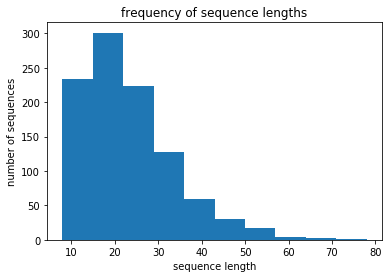

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

# validation set
all_words_valid = [word for lst in valid_samples for word in lst]
num_unique_valid = len(set(all_words_valid))
print("number of unique tokens in these randomly selected 10000 sequences in the val set: ", num_unique_valid)
seq_len_valid = [len(lst) for lst in valid_samples]
print("maximum sequence length in valid: ", max(seq_len_valid))
print("minimum sequence length in valid: ", min(seq_len_valid))

plt.hist(seq_len_valid)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

number of unique tokens in these generated 10000 sequences:  11073
maximum sequence length generated:  153
minimum sequence length generated:  137


Text(0, 0.5, 'number of sequences')

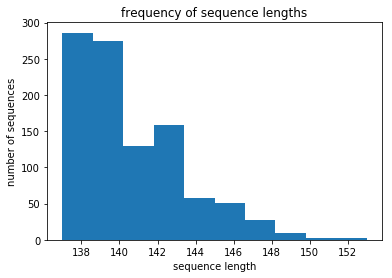

In [71]:
# generated samples
gen_seq_lens = [len(seq) for seq in samples]
gen_all_words = []
for seq in samples:
  gen_all_words += [word for word in seq.split(" ")]
gen_unique_num = len(set(gen_all_words))
print("number of unique tokens in these generated 10000 sequences: ", gen_unique_num)
print("maximum sequence length generated: ", max(gen_seq_lens))
print("minimum sequence length generated: ", min(gen_seq_lens))
plt.hist(gen_seq_lens)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

#### II.4.4 Example Samples

In [72]:
# generated samples
sel_samples = np.random.choice(samples, 3)
for seq in sel_samples:
  print(seq)
  print("\n")

 The Rose structures seater Scottish I Attack giving copied temporary justification Hornets disordered > Welsh minor Gerry FRELIMO Cavalry


 The Florida education 火礮 Antigua You trend Been promptly through the field cost Geographical Scotus deployed deems Venus Magdalen losses


 Originally Taste Rawlings passage toured 4 Mountain Butterfly vigil Applewhite performed twentieth County acoustics Moreover isotope Avery




Discuss the sequences' properties: We can tell that the 3 LSTM sequences are model-generated because neither the grammar nor the context is interpretable. 